In [3]:
%matplotlib inline
from read_yse_ztf_snana_dir import read_YSE_ZTF_snana_dir
from matplotlib.backends.backend_pdf import PdfPages


import glob
import sncosmo
import light_curve
from light_curve import VillarFit
import extinction
from extinction import fm07, apply, remove
import statistics as st

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#plt.style.use('fig_publication.mplstyle')
%config InlineBackend.figure_format = 'retina'

# Load fakes (sims) DF and DR4 DF

In [4]:
import os
os.getcwd()

'/Users/sammysharief/PGM-Project'

In [5]:
fakes_df = pd.read_csv("./SNIa_sims.csv", index_col=0) #Might need to update if you are using SNIa sims
dr4_df = pd.read_csv("./Real_Data.csv", index_col=0)

In [6]:
fakes_df = fakes_df.drop(['X_villar_fit_peak_time', 'Y_villar_fit_peak_time'], axis=1)
dr4_df = dr4_df.drop(['X_villar_fit_peak_time', 'Y_villar_fit_peak_time'], axis=1)

In [7]:
fakes_df = fakes_df.dropna()
dr4_df = dr4_df.dropna()

In [8]:
#fakes_df.to_csv("../Tables/simulated_df_villar_params.csv.gzip", compression='gzip')
# fakes_df

In [9]:
#dr4_df.to_csv("../Tables/real_data_df_villar_params.csv.gzip", compression='gzip')
# dr4_df

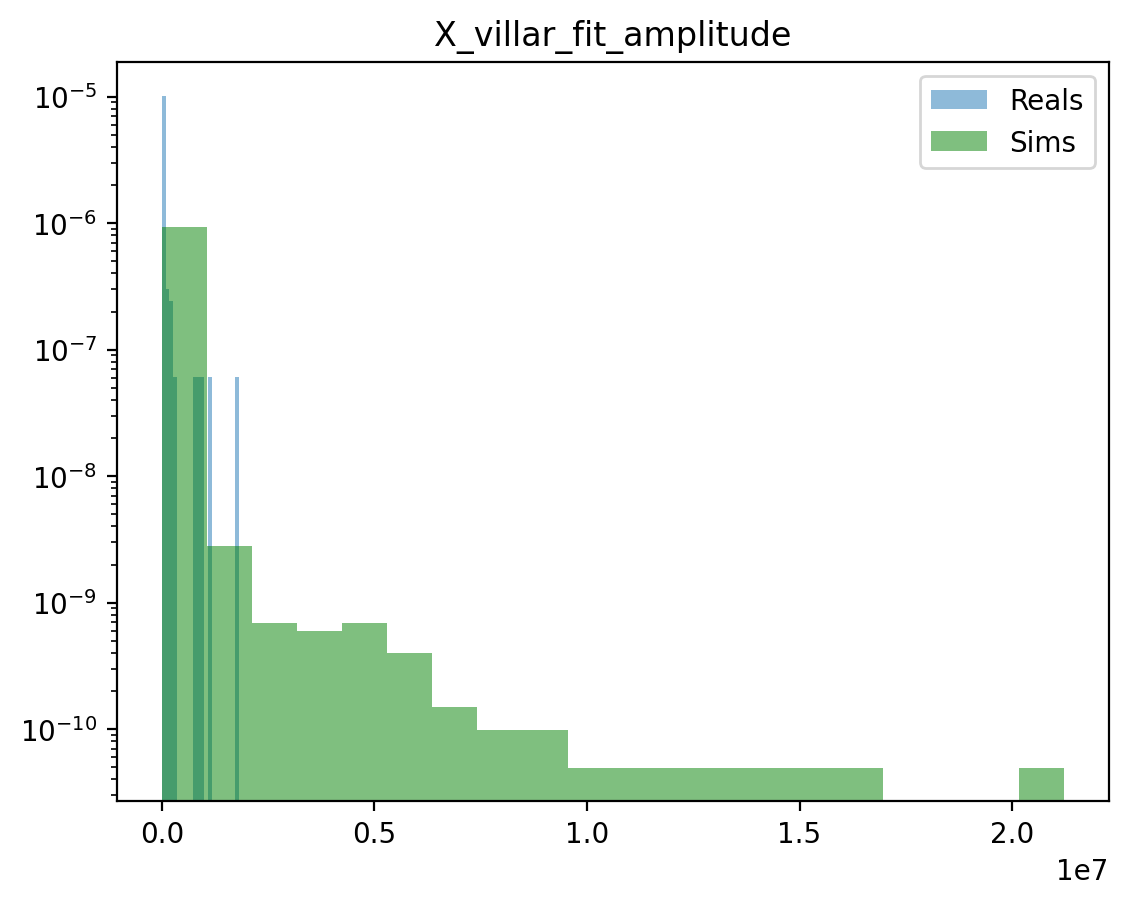

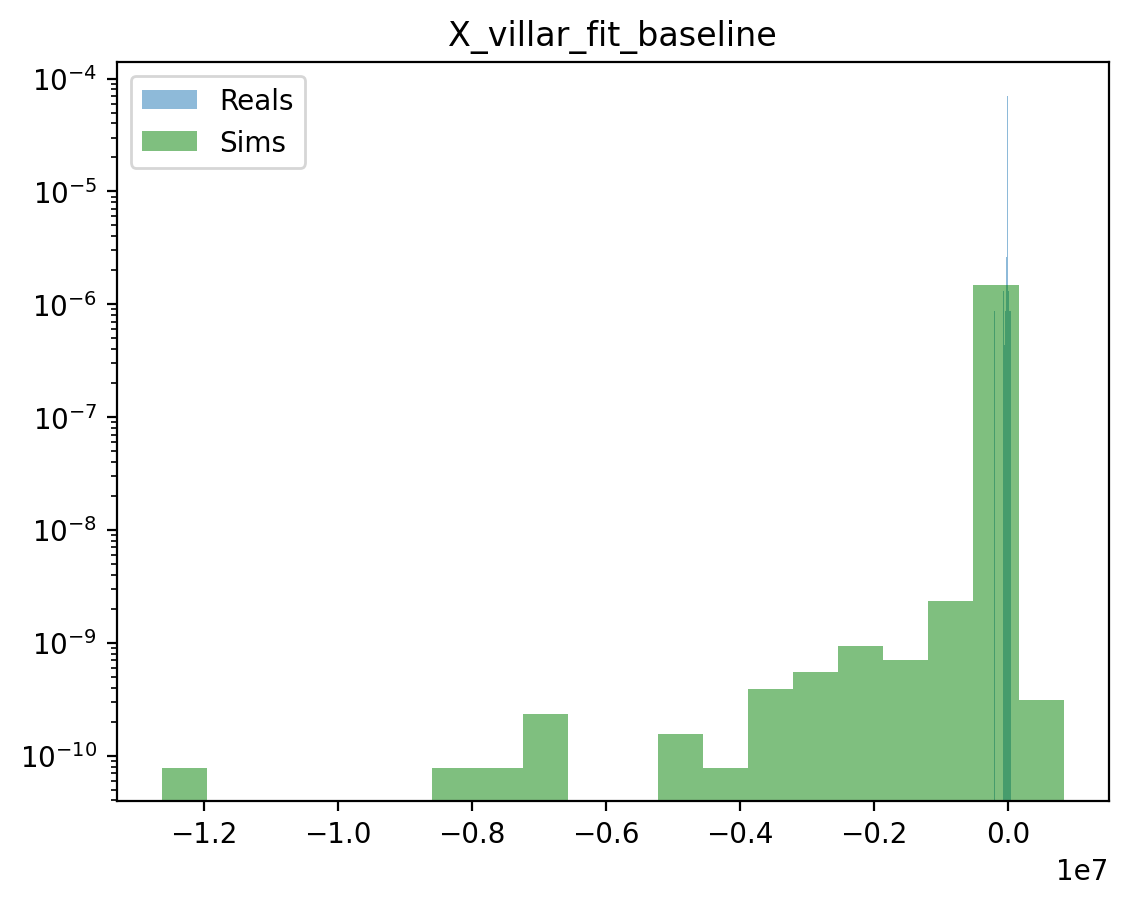

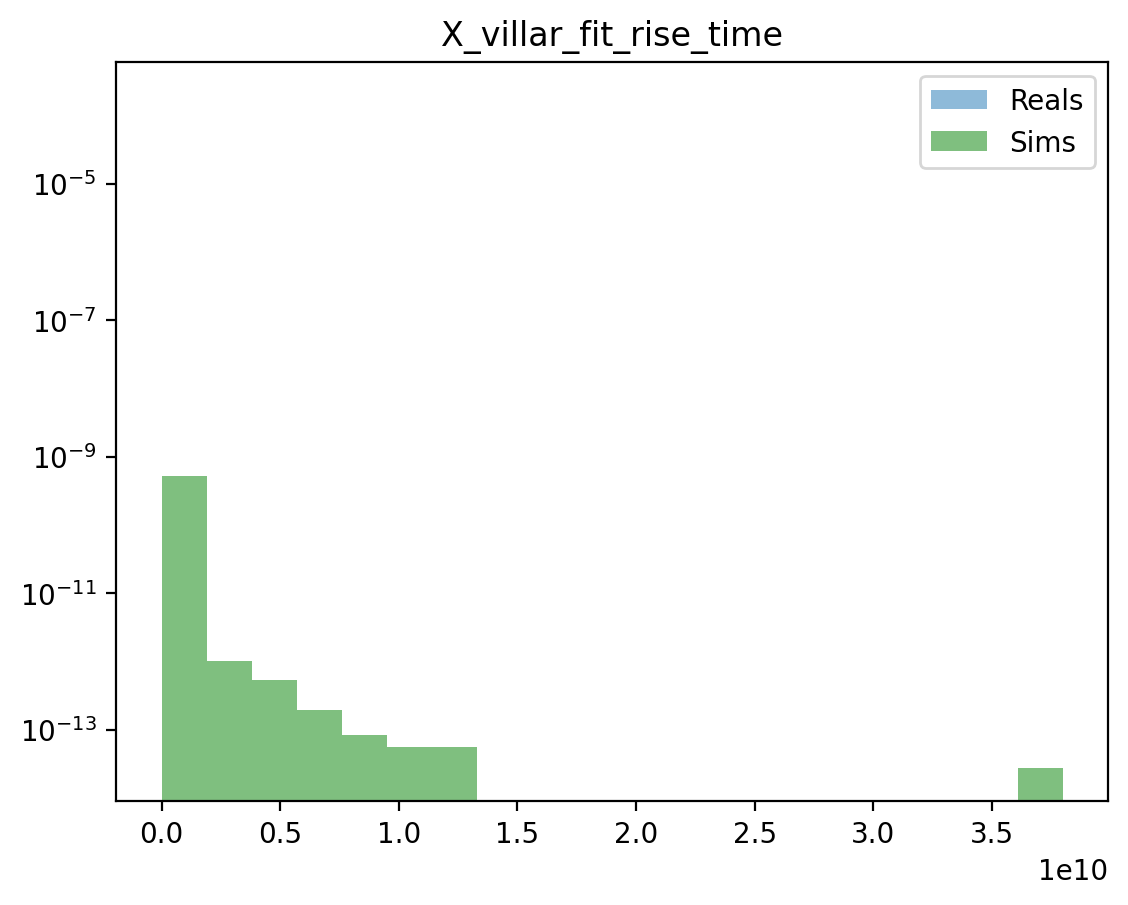

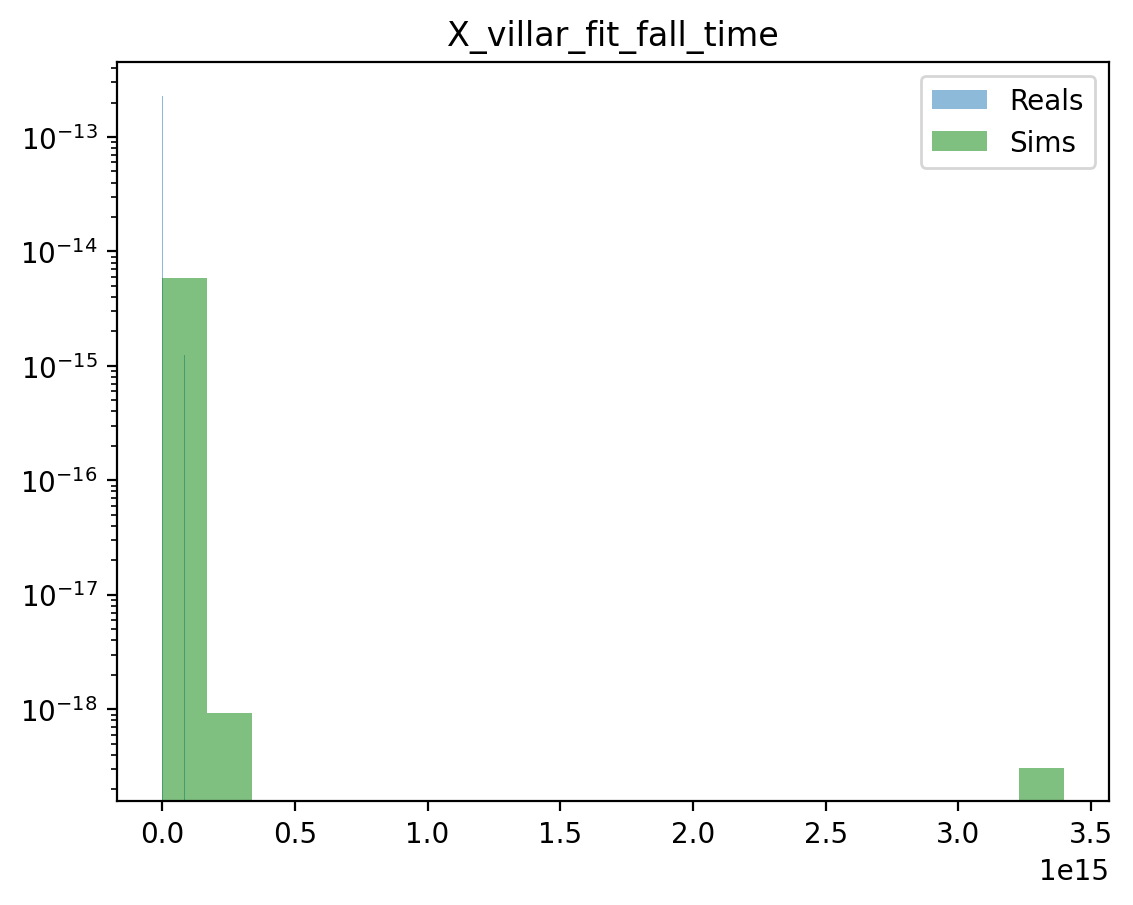

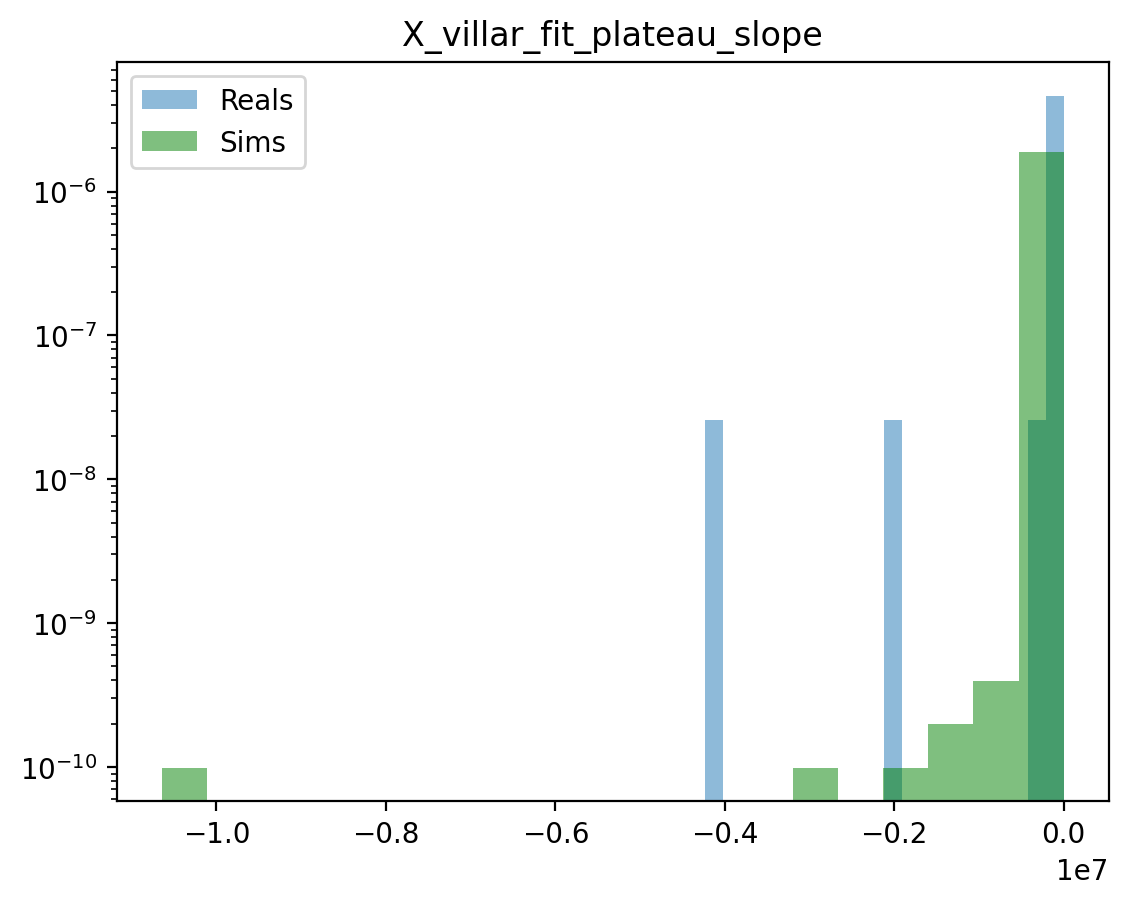

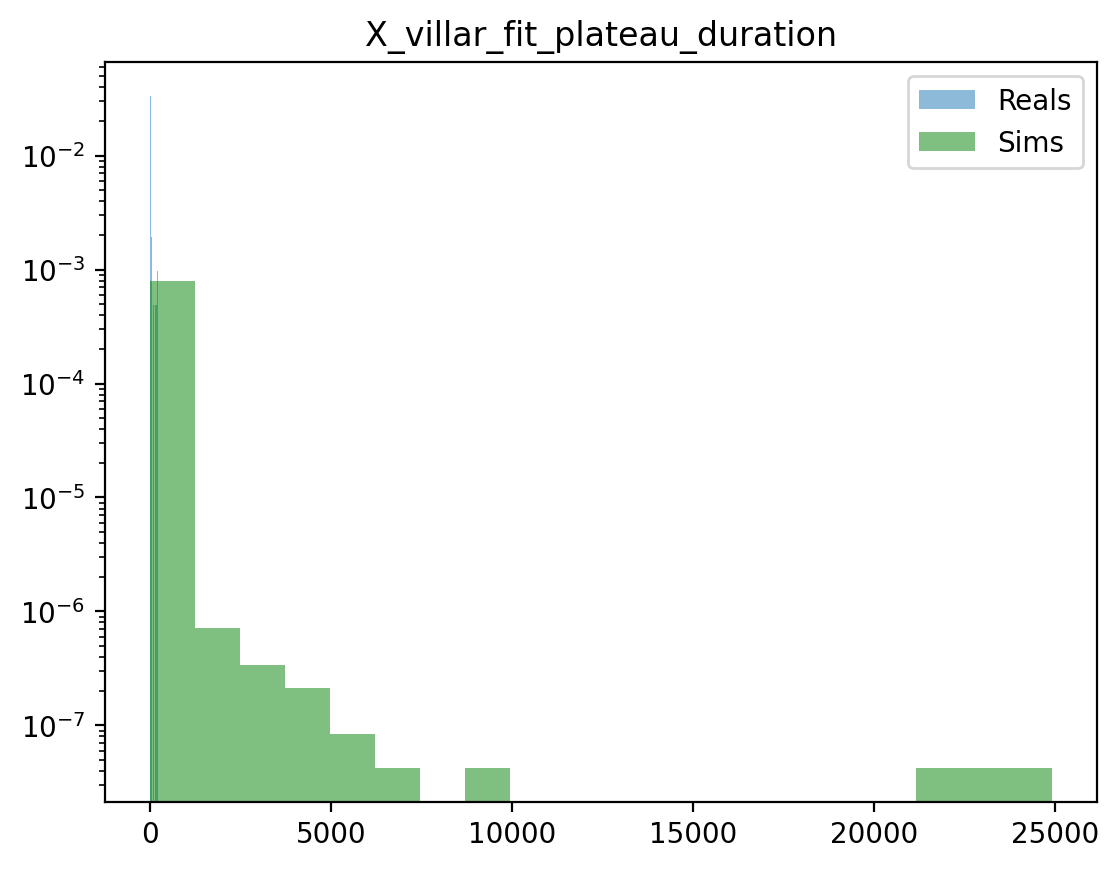

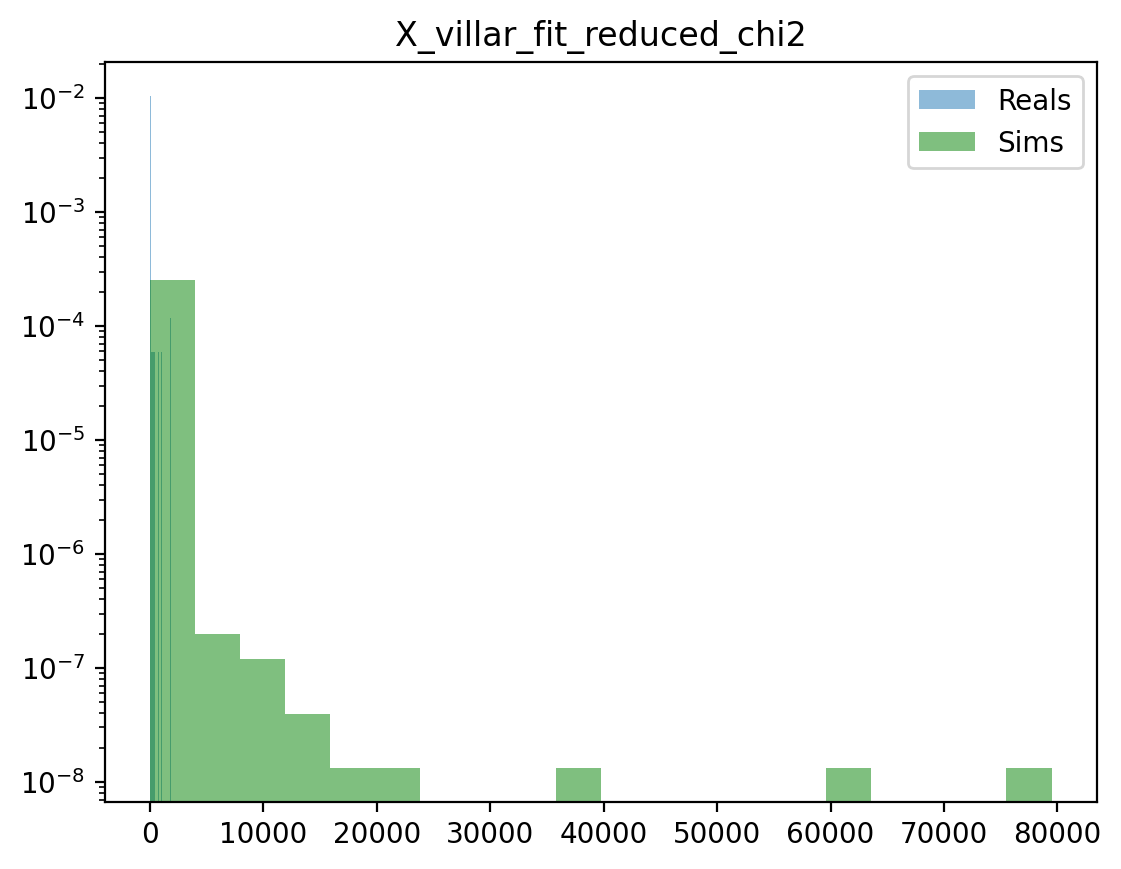

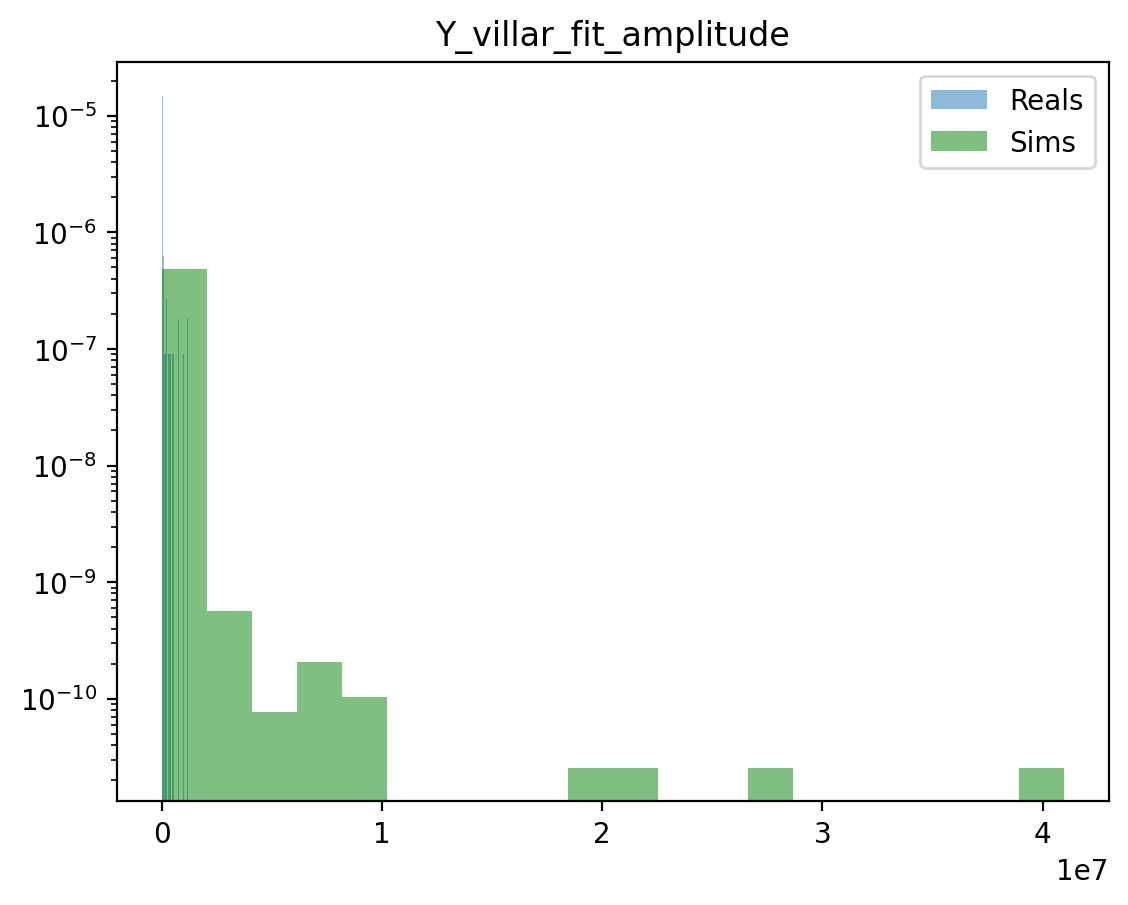

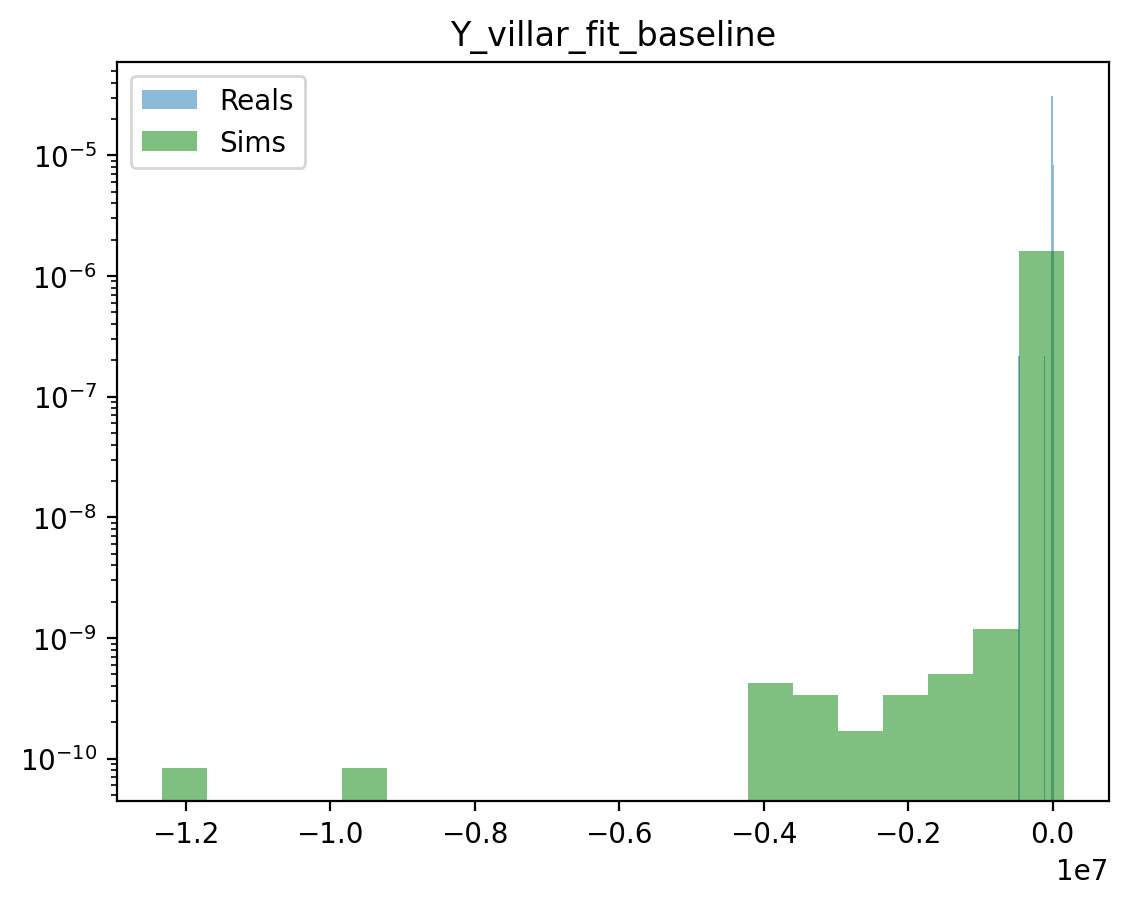

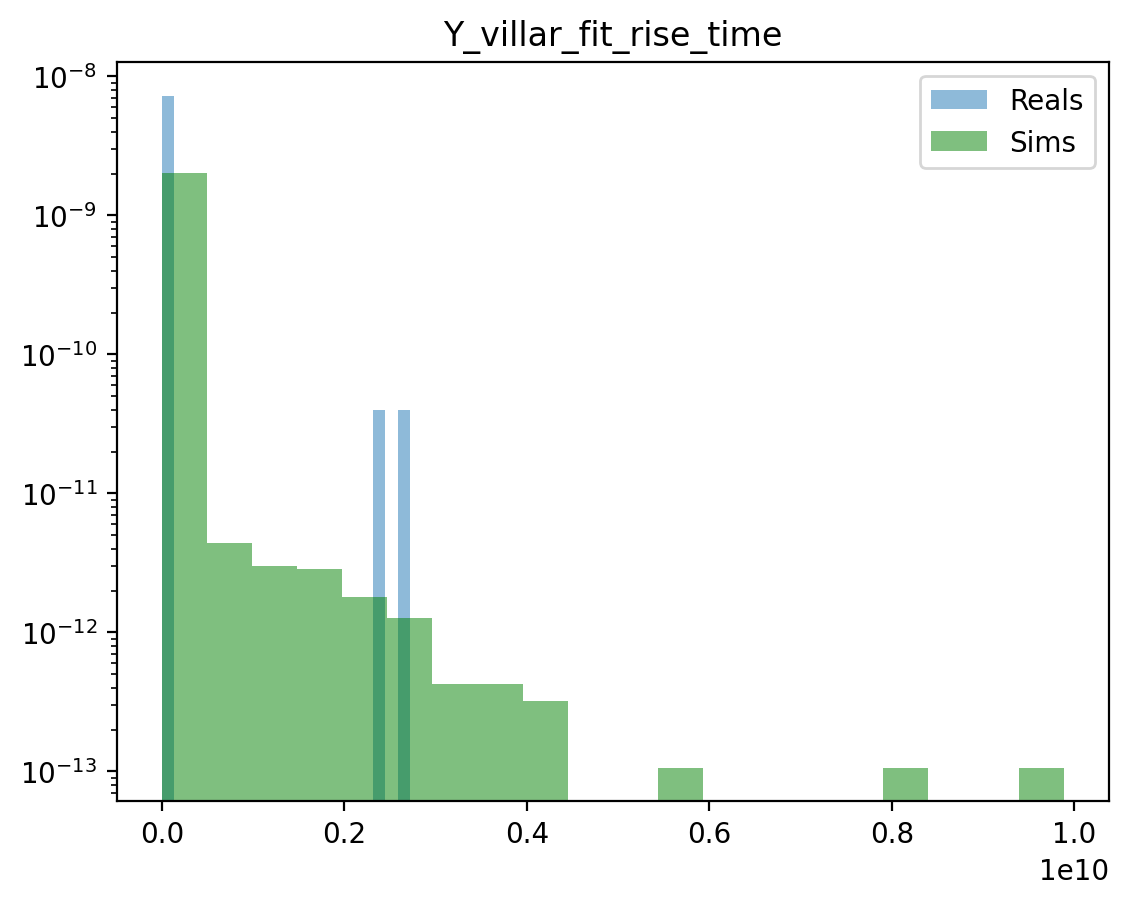

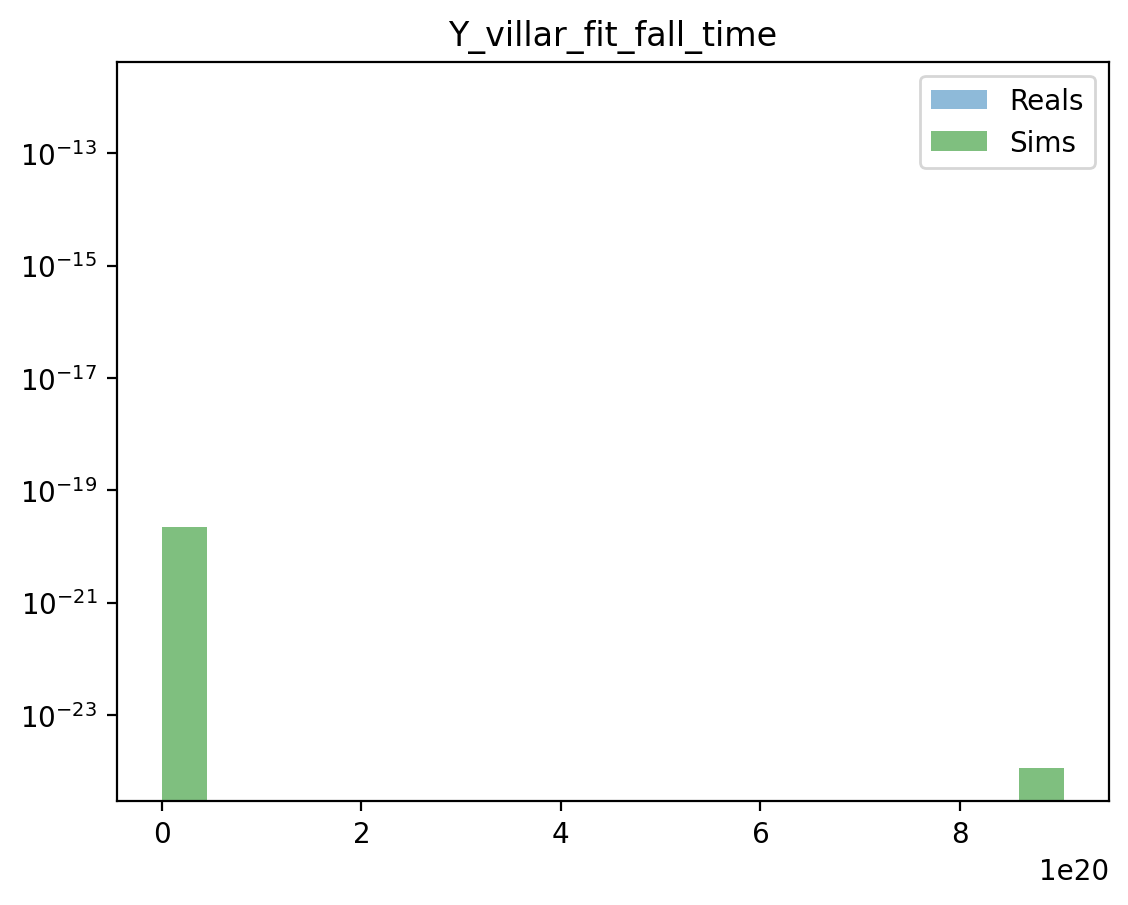

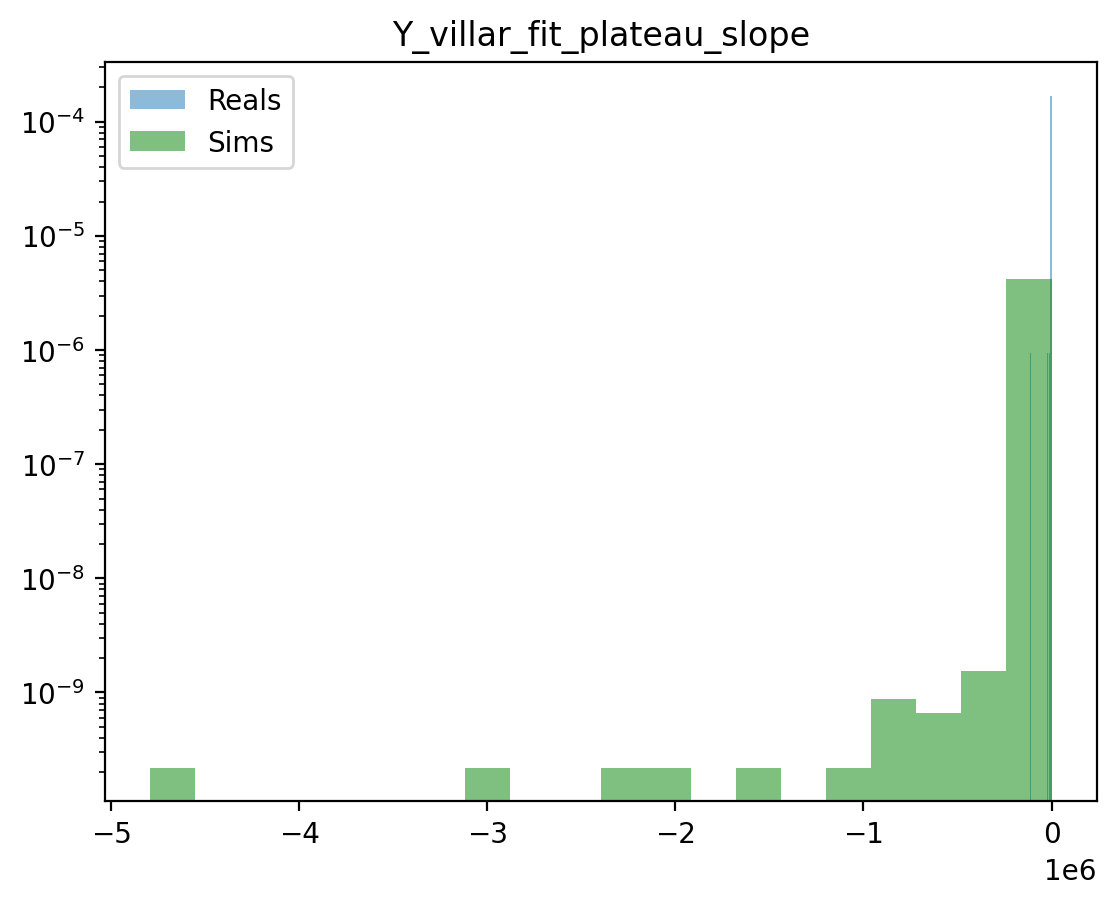

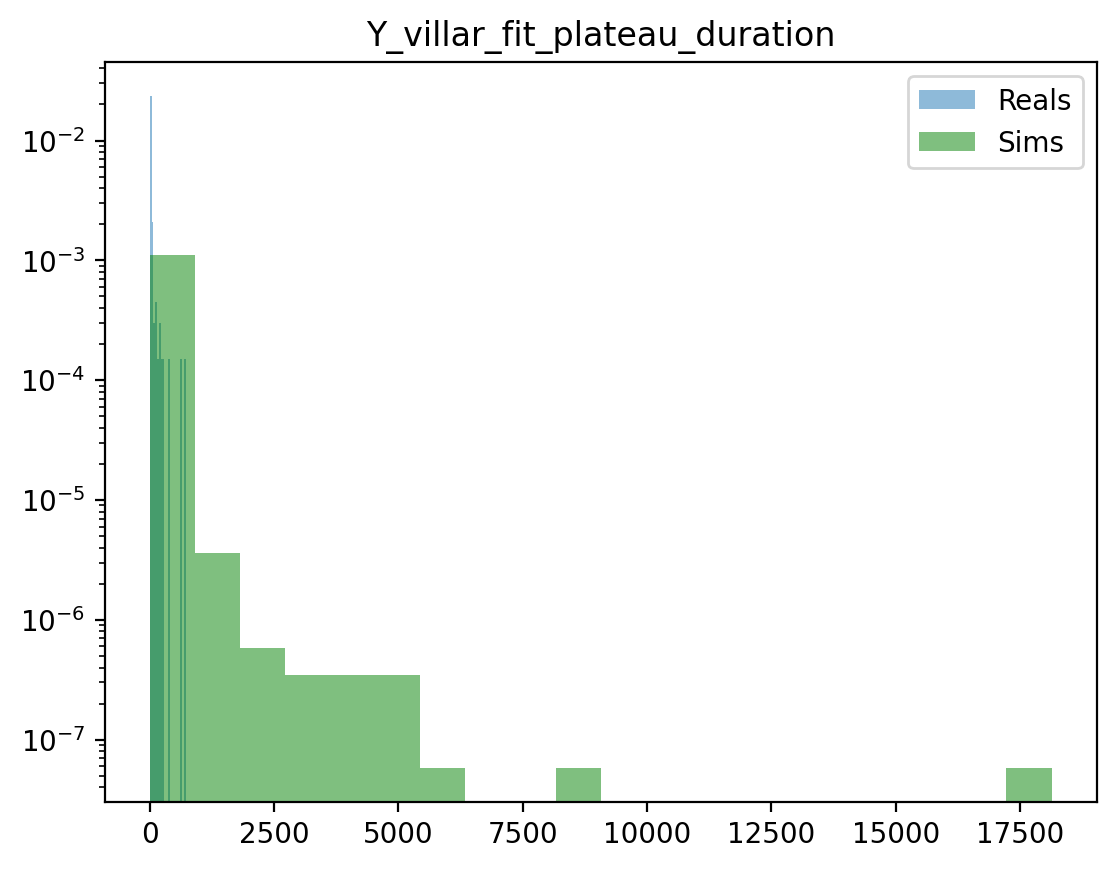

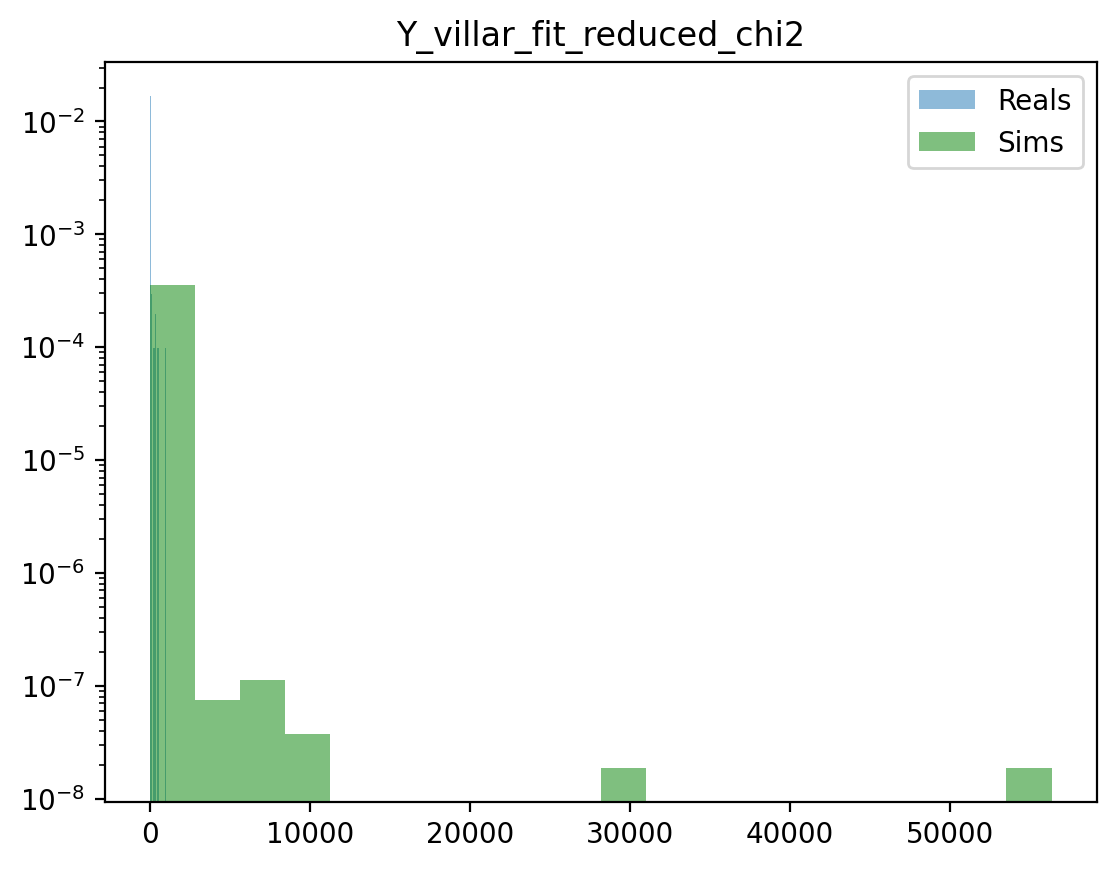

In [10]:
'''
MAX
MIN
MEDIAN
MEAN
Standard Deviation

make an array of the given values for each col for the bins and make a 'loop up table' and get it nice


'''
for col in dr4_df.columns:
    fig = plt.figure()
    plt.hist(dr4_df[col], bins = 20, label = "Reals", density = True, alpha = 0.5)
    plt.hist(fakes_df[col], bins = 20, color = 'g', label = 'Sims', density = True, alpha = 0.5)
    plt.legend()
    plt.yscale('log')
    plt.title(col)
    plt.show()

# PCA 

In [22]:
#Use PCA for real and fake w/ the number of reduced dimension (14 -> 8)
def applypca(dataset_real, dataset_fakes, pca_num):
    X_real = dataset_real
    X_fakes = dataset_fakes
    
    ss = StandardScaler()
    scaled_X_real = ss.fit_transform(X_real)
    pca = PCA(pca_num) # PCA(n_components=8)
    
    # apply same PCA to both real and fakes data
    pcs_X_real = pca.fit_transform(scaled_X_real) #Fit the model with X and apply the dimensionality reduction on X.
    pcs_X_fakes = pca.transform(ss.transform(X_fakes)) #Apply dimensionality reduction to X.
    
    score = pcs_X_real[:,0:2]
    coeff = np.transpose(pca.components_[0:2, :])

    return pca, pcs_X_real, pcs_X_fakes, score, coeff

def applyppca(dataset_real, dataset_fakes, pca_num):
    
    # convert the datasets to numpy arrays (I haven't included the fakes in the EM step yet)
    X_real = dataset_real.to_numpy() 
    X_fakes = dataset_fakes.to_numpy()
    
    t,d = X_real.shape
    
    # initialize W with random numbers, shape (d, pca_num)
    W = np.random.randn(d, pca_num)
    W_hat = np.zeros((d, pca_num))
    
    # calculate the mean across all data points
    mean = np.mean(X_real, axis=0) 
    
    # calculate S
    S = (1/t)*(X_real - mean[np.newaxis,:]).T @ (X_real - mean[np.newaxis,:])
    
    # initialize the variance to 1
    var = 1

    # calculate the norm squared between current and past weight matrix as a convergence metric
    norm = np.linalg.norm(W-W_hat)**2
    
    # EM step
    while norm > 0.0001:
        
        # calculate M and its inverse
        M = W.T @ W + var * np.eye(pca_num)
        M_inv = np.linalg.pinv(M)
        
        # update W
        W_hat = S @ W @ np.linalg.pinv(var * np.eye(pca_num) +(M_inv @ W.T @ S @ W)) 
        
        # update the variance with new W
        var = (1/d)*np.trace(S - S @ W @ M_inv @ W_hat.T)
        
        # update the norm squared
        norm = np.linalg.norm(W-W_hat)**2
        
        # set current W to old W
        W = W_hat

    # apply the derived W to the centred data 
    pca_X_real = W.T @ (X_real - mean[np.newaxis,:]).T 
    
    # calculate the score and coeffs from the pca application and W
    score = pca_X_real.T[:,0:2]
    coeff = np.transpose(W.T[0:2, :])

    return W, var, pca_X_real, score, coeff

ss = StandardScaler()
smaller = ss.fit_transform(dr4_df)
test = pd.DataFrame(smaller)

# pca, pcs_X_real, pcs_X_fakes, score, coeff = applypca(dataset_real=dr4_df, dataset_fakes=fakes_df, pca_num=8)

W, var, pcs2_X_real, score2, coeff2 = applyppca(dataset_real=test, dataset_fakes=fakes_df, pca_num=8)

# comparison between original PCA and new PPCA
print('original',pcs_X_real[0])
print('new',pcs2_X_real.T[0])


original [-0.33723551 -0.3257651  -0.12287215  0.10656381  0.09899164  0.02044625
 -0.01341096 -0.25072137]
new [-0.2450846  -0.1281847  -0.32011364 -0.12295056  0.4701542  -0.05872074
  0.33263513 -0.21964359]


In [23]:
#Function to plot the result of the PCA 3 cells down
def pcaplot(score, coeff, datacolor, dataframe):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs*scalex,ys*scaley, c=datacolor, s=6, alpha=0.6) 
    plt.xlim(-1,1)
    plt.ylim(-1,1) 
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], head_width= .003, color = 'r',alpha = 0.5)
        #dataframe_latex_read = [r.replace('_', '\_') for r in dataframe.columns.values]
        plt.text(coeff[i,0]* 1.12, coeff[i,1] * 1.12, list(dataframe.columns.values)[i], 
                    color = 'darkblue', ha = 'center', va = 'center', fontsize = 10)

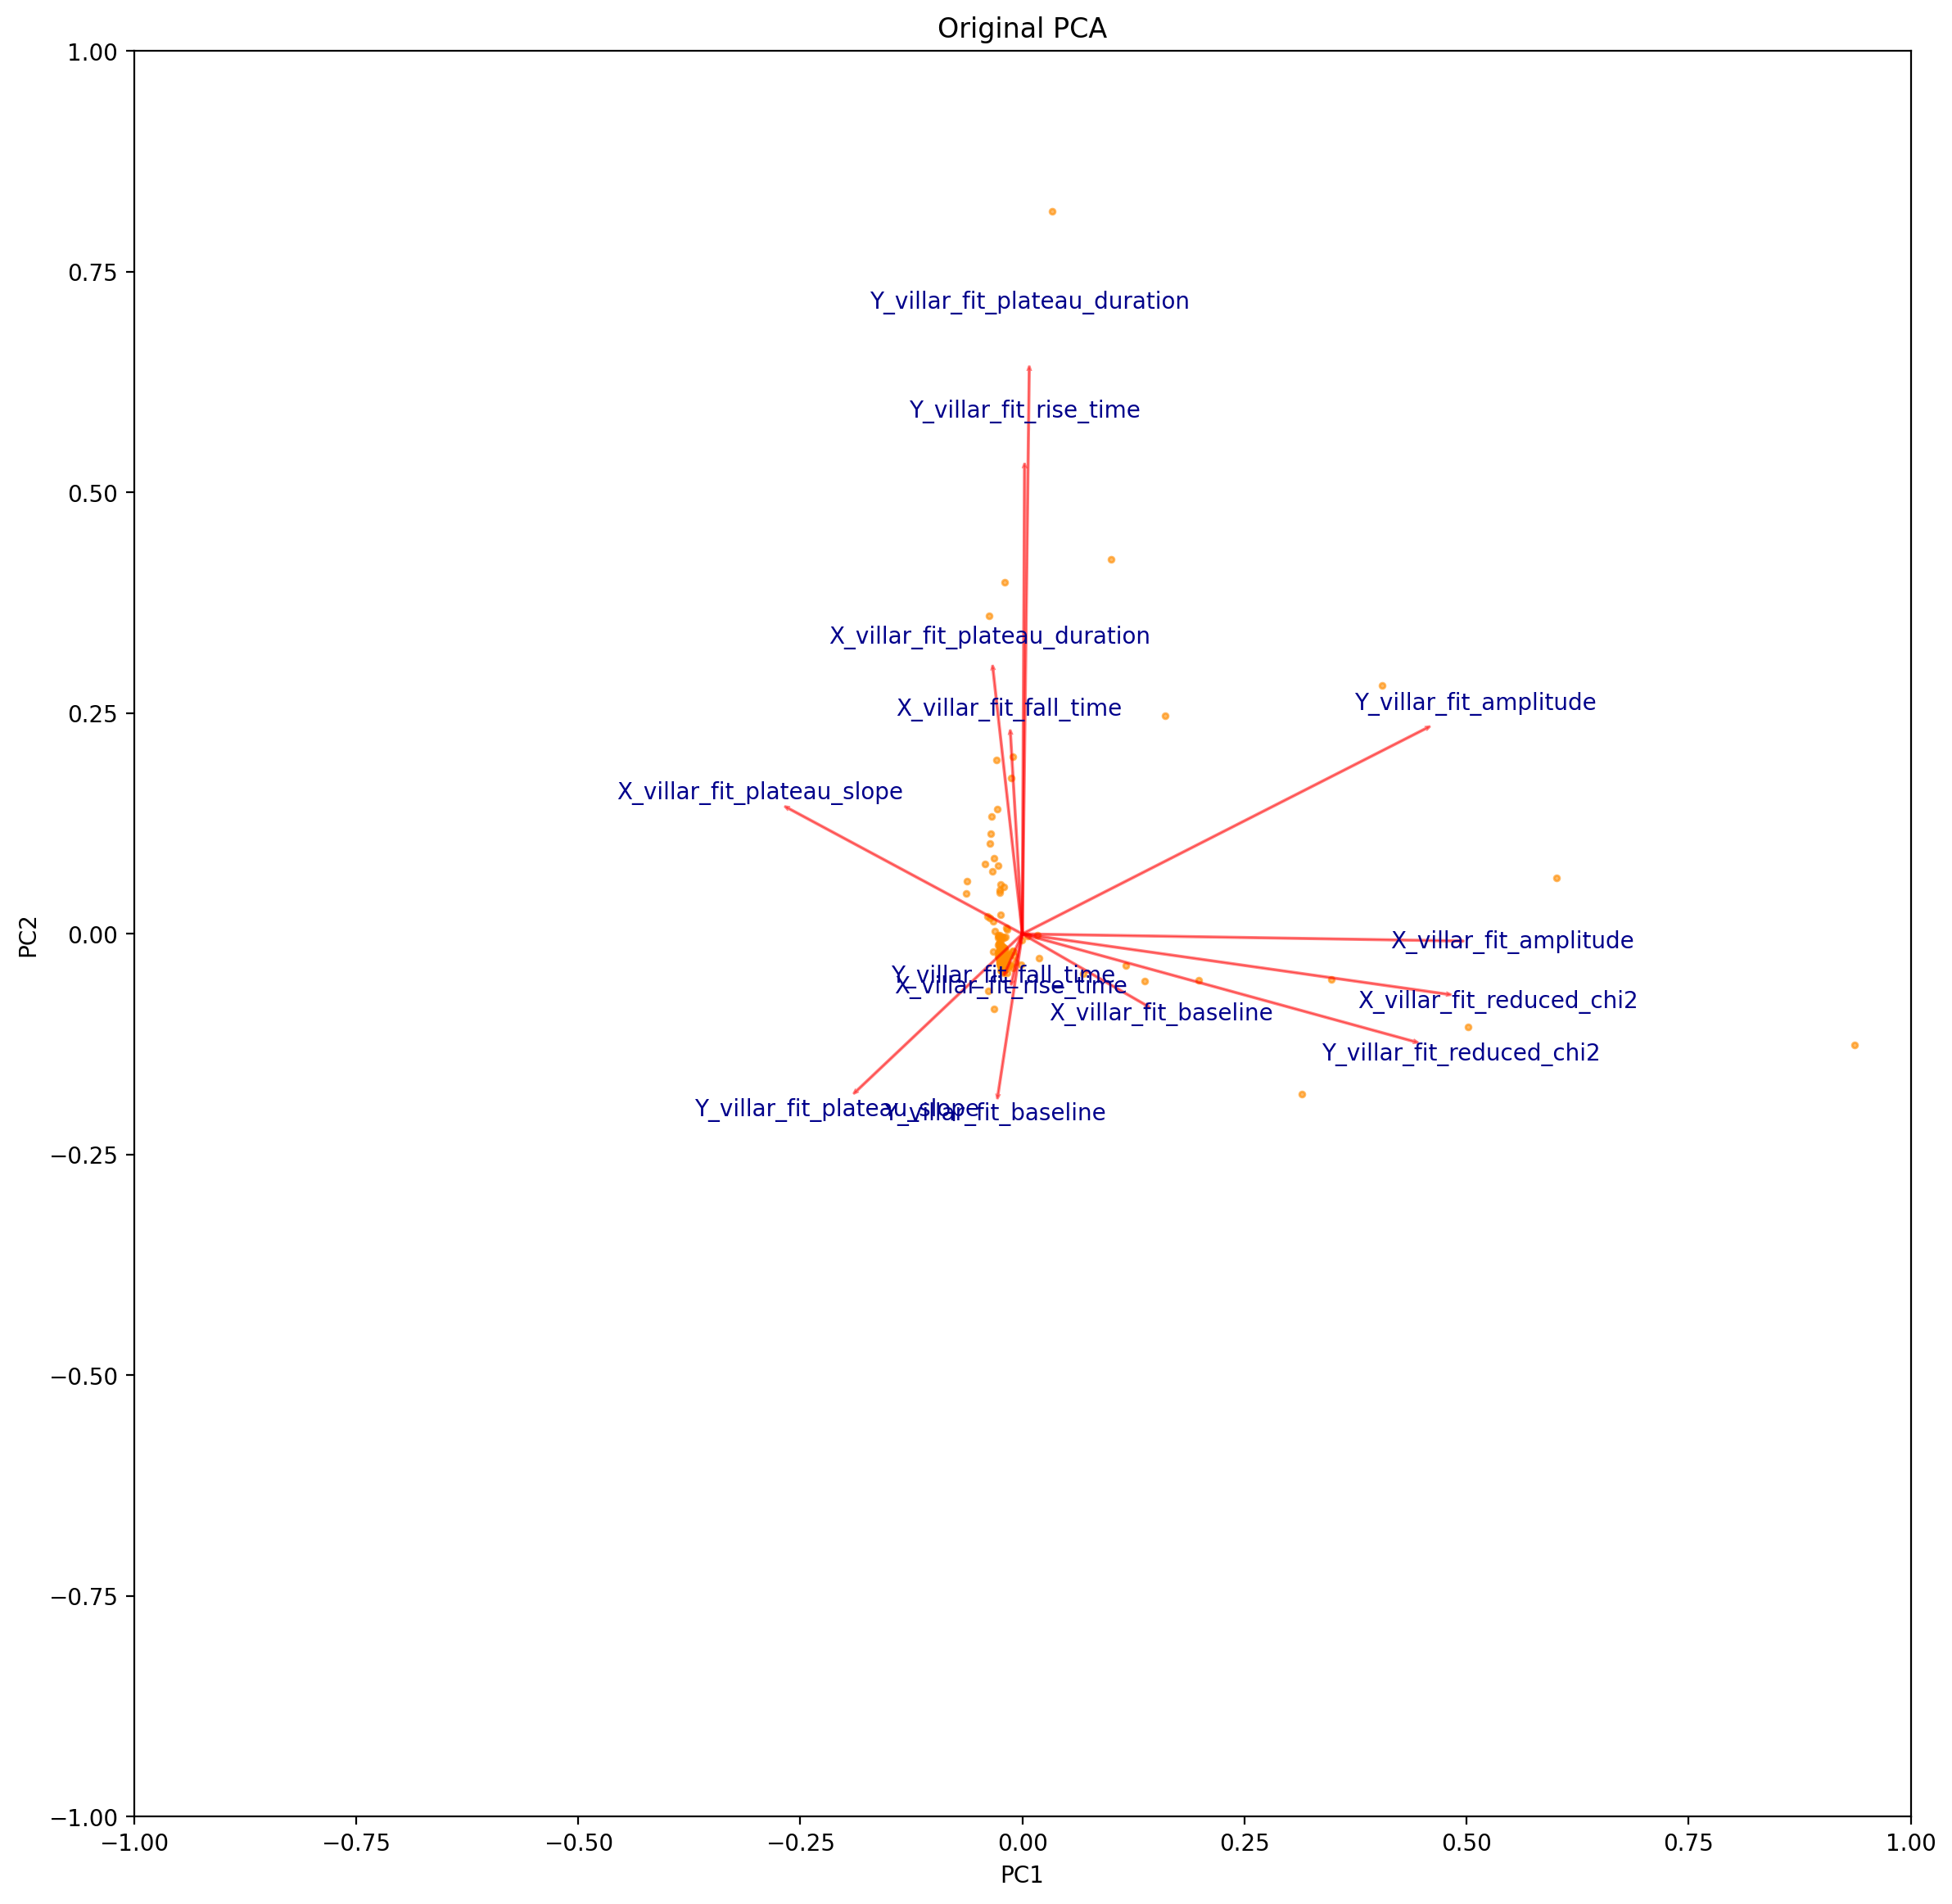

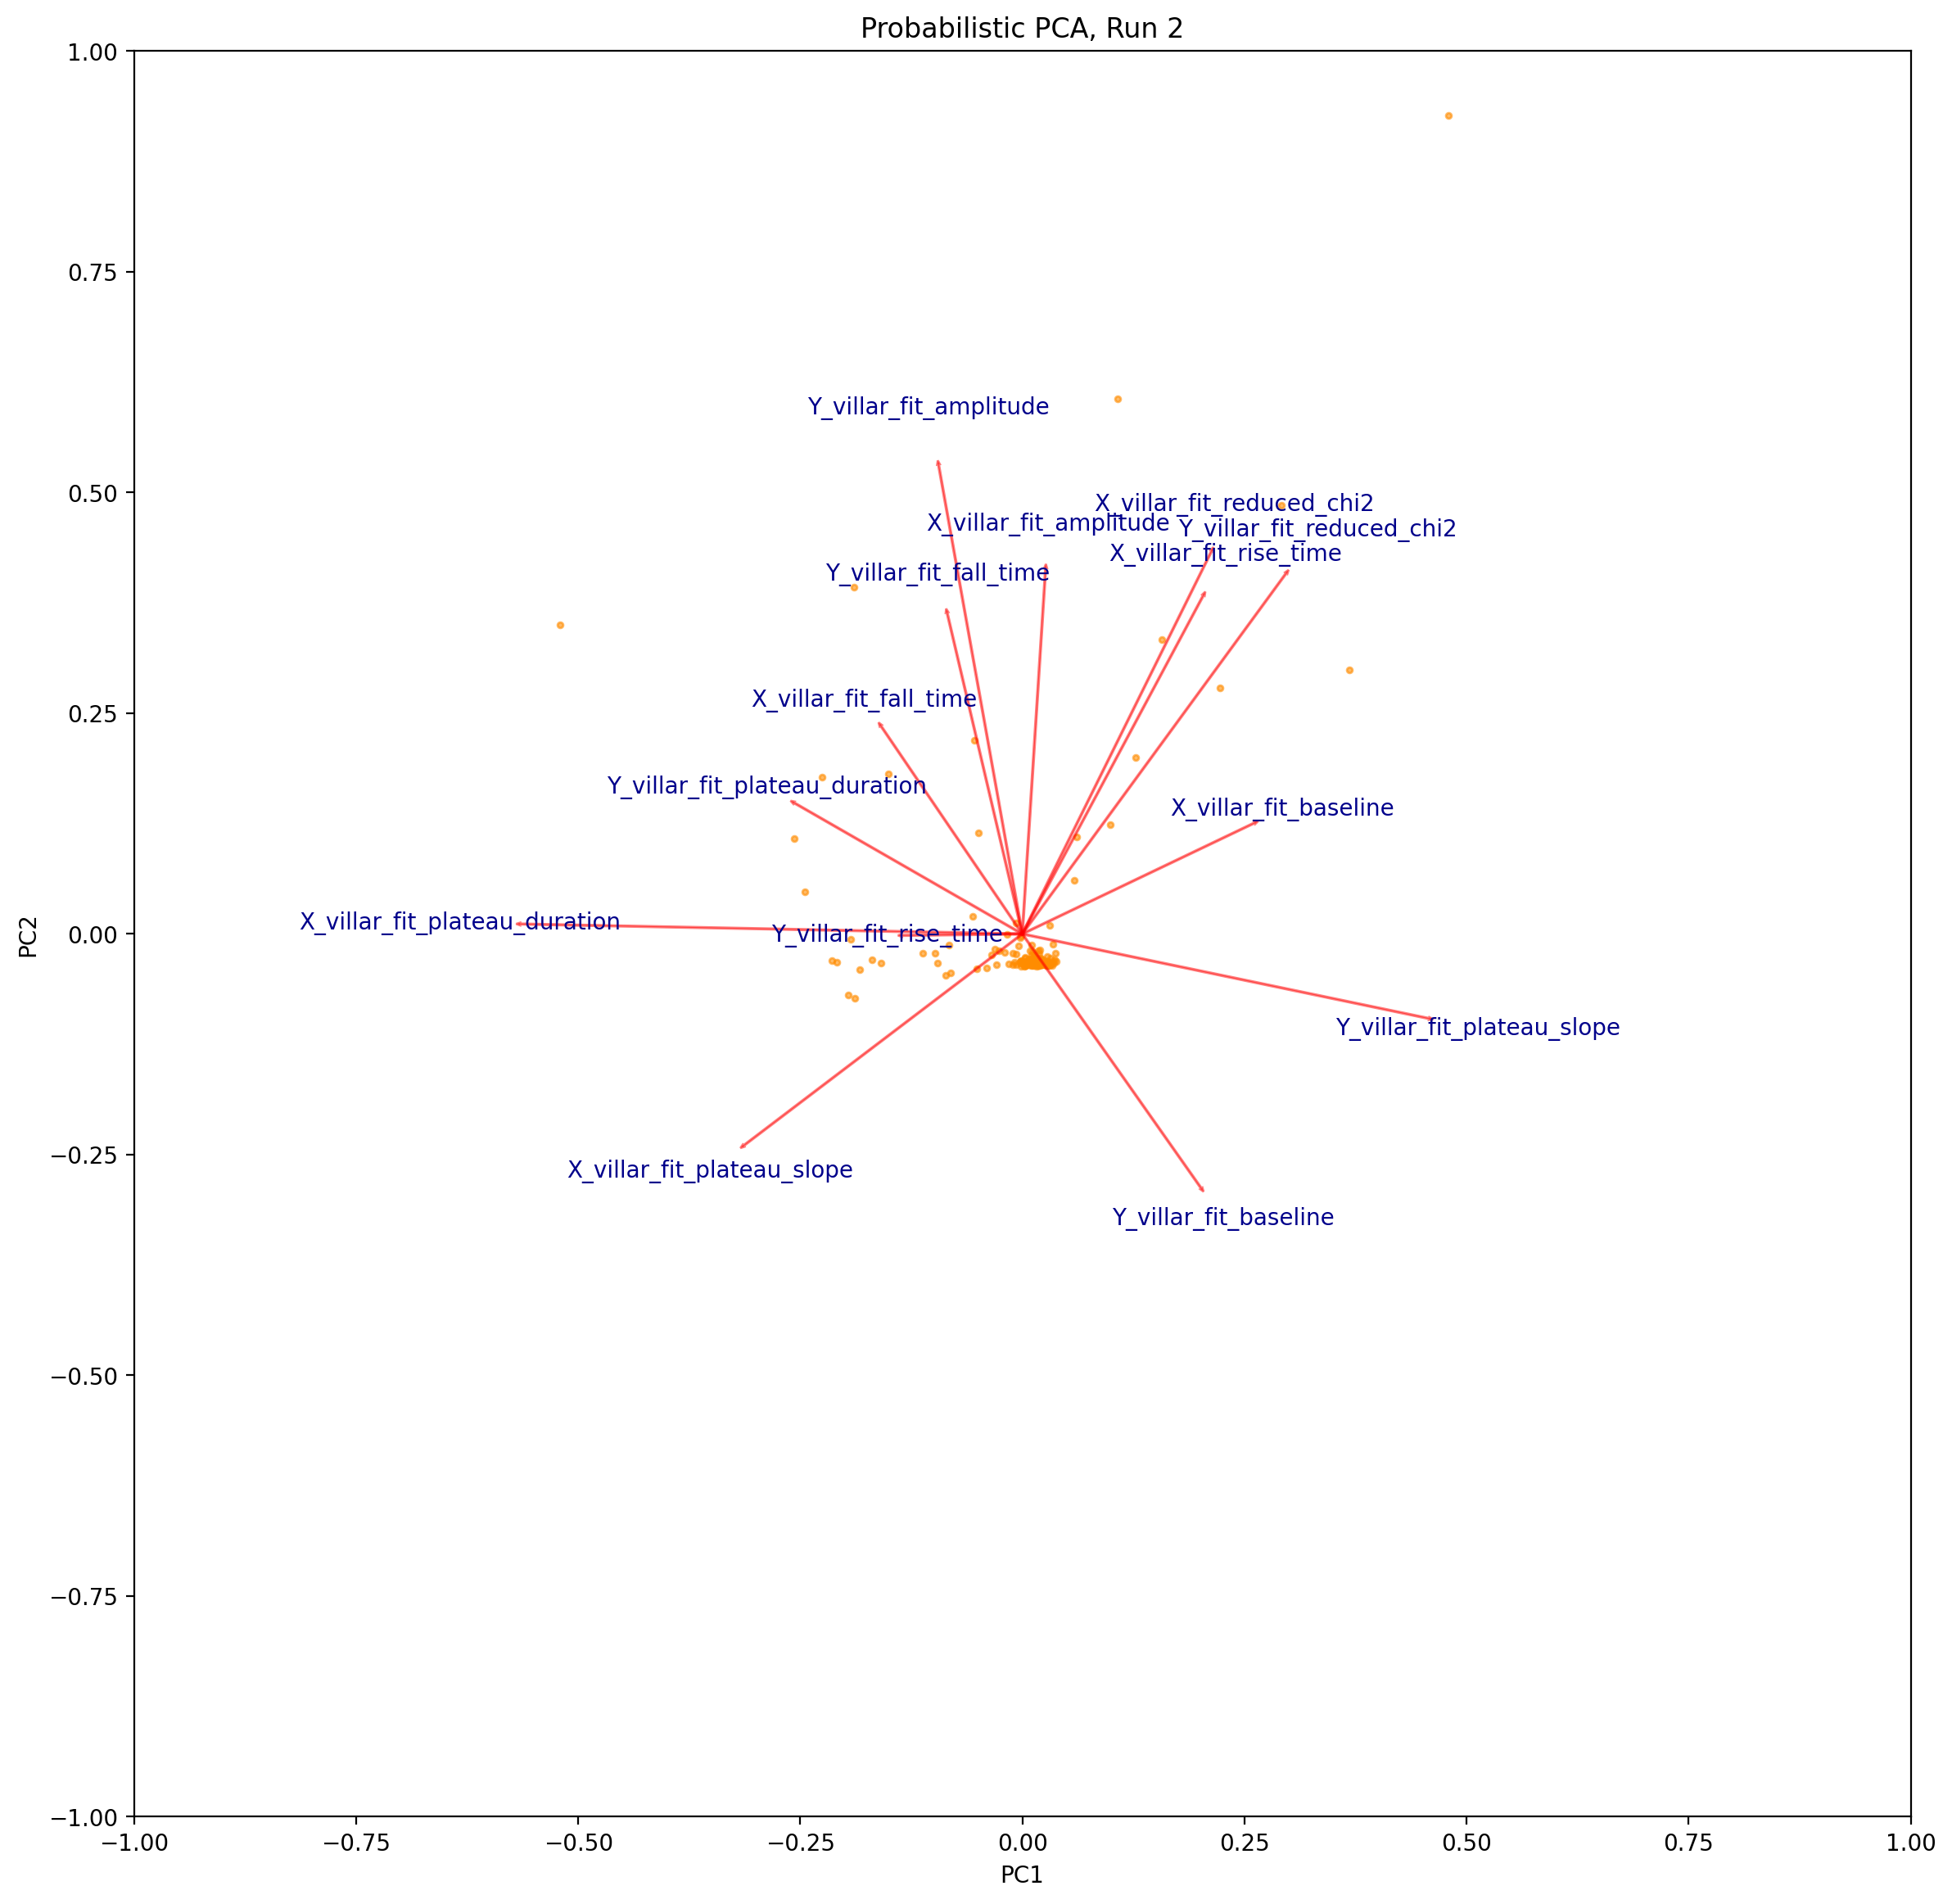

In [13]:
fig, ax = plt.subplots(figsize=(14, 14))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Original PCA")
pcaplot(score, coeff, 'darkorange', dataframe = fakes_df) 
#plt.savefig('./figures/pca_overlay_data.png', dpi=300, bbox_inches='tight')
#Grouping means correleated. Further out means less coreleated

fig, ax = plt.subplots(figsize=(14, 14))
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Probabilistic PCA, Run 2")
pcaplot(score2, coeff2, 'darkorange', dataframe = fakes_df) 

# Build DFs from first (8) PCs

In [14]:


pcs_X_fakes_df = pd.DataFrame(data=pcs_X_fakes, index=fakes_df.index)
pcs_X_fakes_df

,0,1,2,3,4,5,6,7
ObjectID,,,,,,,,
_4877922_SNIa,-0.438571,-0.363295,0.219247,-0.179002,-0.103088,0.037320,-0.196169,-0.026946
_1309355_SNIa,-4724.538826,-21623.762508,-28845.217159,37551.258185,123281.173974,275672.642793,48402.135759,255771.838327
_3053534_SNIa,-0.479680,-0.085918,0.259258,-0.109886,-0.037340,0.013119,-0.033366,-0.129866
_3315509_SNIa,-0.420818,2.765126,-1.627507,-0.270707,0.090012,0.009551,0.031486,-0.045830
_4109434_SNIa,-0.317573,-0.493407,-0.314294,0.181468,0.169657,0.025867,-0.007499,-0.313391
...,...,...,...,...,...,...,...,...
_2303364_SNIa,0.234168,-0.393072,-0.166580,0.054349,0.007098,0.018747,-0.044363,-0.187997
_4431841_SNIa,-0.442579,-0.216530,-0.297978,0.032127,0.024021,0.033968,-0.106507,-0.159553
_3414162_SNIa,-0.490665,-0.340492,0.247623,-0.165110,-0.171067,0.032360,-0.197086,0.001216


In [15]:
# pcs_X_real_df = pd.DataFrame(data=pcs_X_real, index=dr4_df.index)
# pcs_X_real_df
# print(pcs_X_real.shape)
# print(pcs2_X_real.shape)
pcs2_X_real_df = pd.DataFrame(data=pcs2_X_real.T, index=dr4_df.index)
pcs2_X_real_df

,0,1,2,3,4,5,6,7
ObjectID,,,,,,,,
2019pmd,0.226810,-0.468828,-0.076193,0.002888,0.231481,0.292894,0.236603,0.323731
2019tvv,0.154068,-0.398761,-0.013207,-0.032398,0.210874,0.181459,0.193921,0.249429
2019wka,0.401038,-0.423268,-0.072789,0.070354,0.247018,0.216273,0.162287,0.369462
2019wqf,-3.618444,1.808803,-5.648613,4.922570,-7.255941,2.957261,-1.212518,-4.912627
2019wyp,-1.376830,-0.371348,-0.053788,-0.349441,-0.085269,0.617869,0.448781,-0.336609
...,...,...,...,...,...,...,...,...
2021wfn,0.271374,-0.597259,-0.122851,-0.009671,0.262007,0.424632,0.349650,0.405087
2021wue,0.174651,-0.560683,-0.118414,-0.026854,0.240092,0.416049,0.331391,0.349123
2021xjh,-0.095127,-0.379679,-0.471709,0.439862,-0.427682,0.876024,0.314533,0.025432


# Find variance of 8 PCs...

In [16]:
#Percentage of variance explained by each of the selected components.
pca_var_ratio = pca.explained_variance_ratio_
pca_var_ratio

# calculate the variance at each dimension 
pca2_var = np.var(W, axis=0)

print(pca2_var.shape, pca_var_ratio.shape)

(8,) (8,)


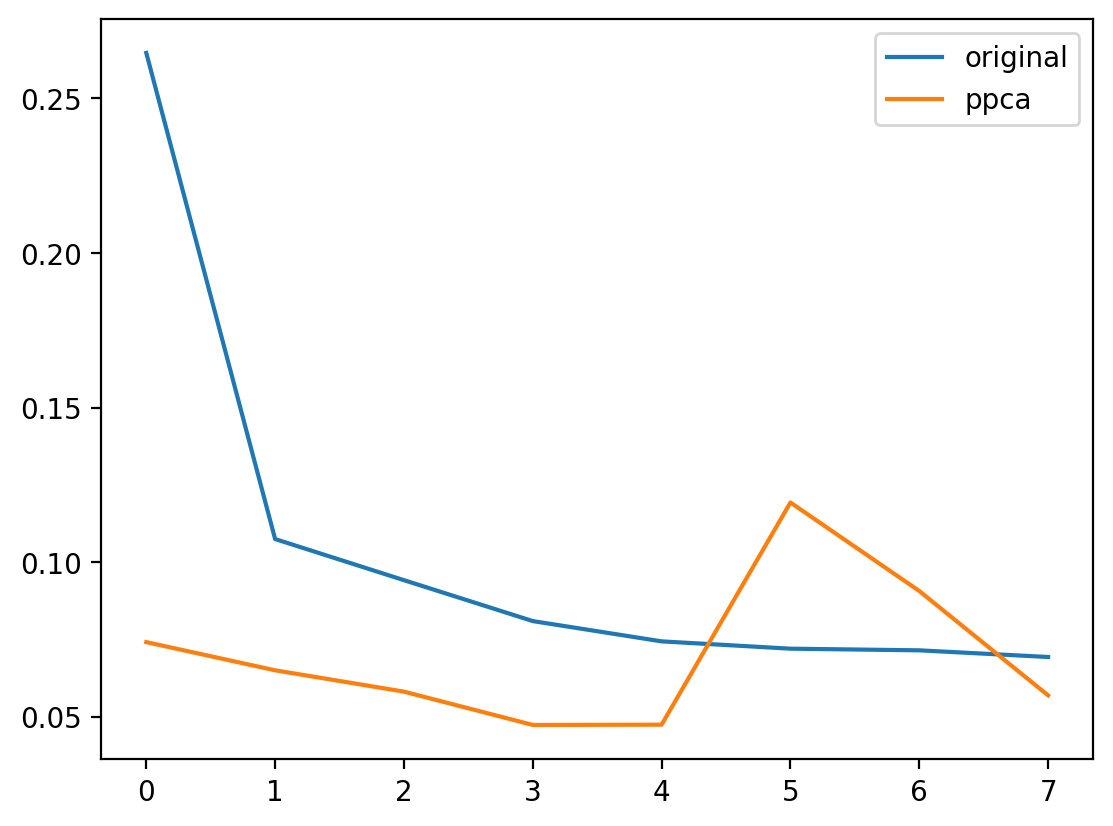

normal pca [0.26471202 0.37221455 0.46641854 0.54739129 0.6218037  0.69385091
 0.76536521 0.83472238]
new ppca [0.07416918 0.13921894 0.19737228 0.24475034 0.29221545 0.41155176
 0.50225622 0.55920595]


In [17]:
plt.plot(pca_var_ratio, label='original')
plt.plot(pca2_var, label='ppca')
plt.legend()
plt.show()

print('normal pca', np.cumsum(pca_var_ratio))
print('new ppca', np.cumsum(pca2_var))

In [18]:
print("summed variance First 14 PCs:", np.cumsum(pca_var_ratio)[-1])

print("summed variance First 14 PCs PPCA:", np.cumsum(pca2_var)[-1])

summed variance First 14 PCs: 0.8347223818278634
summed variance First 14 PCs PPCA: 0.5592059473120667


# Most important features mathematically

In [25]:
print(abs( W)) #has shape (8, 14) [n_components, n_features].

[[0.12074909 0.08151869 0.34271712 0.04249159 0.47174571 0.10801951
  0.49299663 0.51443961]
 [0.58729592 0.14561048 0.06595258 0.13254244 0.18870937 0.23900159
  0.00970838 0.12890517]
 [0.05905745 0.0491872  0.31797637 0.03501936 0.21952388 0.31035953
  0.57837029 0.15746779]
 [0.0103123  0.18547226 0.12500244 0.52936642 0.08225362 0.35612032
  0.16340406 0.31658577]
 [0.04972553 0.29646256 0.03172654 0.01561432 0.38271793 0.10887957
  0.18931532 0.30294733]
 [0.49677068 0.18124179 0.14828082 0.04763279 0.1786775  0.23202835
  0.21032863 0.06319452]
 [0.17992593 0.05397959 0.23531585 0.09440501 0.54894375 0.1962145
  0.39220105 0.4619104 ]
 [0.00400651 0.26695101 0.30625068 0.27220934 0.51326329 0.33845307
  0.31165487 0.35101682]
 [0.26176523 0.35198321 0.17084326 0.49333663 0.02349408 0.32261386
  0.23678414 0.13838329]
 [0.24695933 0.01472127 0.27958844 0.22079382 0.24030826 0.30579338
  0.02958024 0.42253001]
 [0.01298722 0.30038627 0.46608409 0.16882634 0.40843122 0.28974272
  0

In [28]:
#df to show for each of the dimension, the pca.components_ --> notice it is the same but above we did abs value 
pca_num = []
for i in range(0, 8):
    pca_num.append('PCA{}'.format(i + 1))

pca_comp = pd.DataFrame(W.T, index=pca_num, columns=dr4_df.columns)
#pca_comp.to_csv('./dataframes/pca_feature_importance.csv')
pca_comp

,X_villar_fit_amplitude,X_villar_fit_baseline,X_villar_fit_rise_time,X_villar_fit_fall_time,X_villar_fit_plateau_slope,X_villar_fit_plateau_duration,X_villar_fit_reduced_chi2,Y_villar_fit_amplitude,Y_villar_fit_baseline,Y_villar_fit_rise_time,Y_villar_fit_fall_time,Y_villar_fit_plateau_slope,Y_villar_fit_plateau_duration,Y_villar_fit_reduced_chi2
PCA1,-0.120749,-0.587296,-0.059057,-0.010312,0.049726,0.496771,-0.179926,0.004007,-0.261765,0.246959,0.012987,0.109726,0.295678,-0.133667
PCA2,0.081519,0.145610,0.049187,-0.185472,0.296463,0.181242,-0.053980,0.266951,-0.351983,0.014721,0.300386,-0.539998,-0.003065,-0.165664
PCA3,0.342717,0.065953,0.317976,0.125002,-0.031727,0.148281,0.235316,0.306251,0.170843,0.279588,-0.466084,-0.394040,0.309669,0.143503
PCA4,0.042492,0.132542,-0.035019,0.529366,-0.015614,0.047633,0.094405,0.272209,-0.493337,-0.220794,-0.168826,0.030672,0.050084,0.103760
PCA5,-0.471746,-0.188709,-0.219524,-0.082254,0.382718,0.178678,-0.548944,-0.513263,0.023494,-0.240308,-0.408431,-0.057078,-0.280379,-0.540811
PCA6,0.108020,0.239002,-0.310360,-0.356120,-0.108880,-0.232028,0.196214,0.338453,-0.322614,0.305793,-0.289743,0.094191,0.152645,0.208272
PCA7,-0.492997,-0.009708,0.578370,-0.163404,0.189315,-0.210329,-0.392201,-0.311655,-0.236784,0.029580,-0.062941,0.356775,-0.037903,-0.325128
PCA8,0.514440,-0.128905,0.157468,-0.316586,-0.302947,0.063195,0.461910,0.351017,-0.138383,-0.422530,-0.149407,-0.157340,-0.507109,0.469845


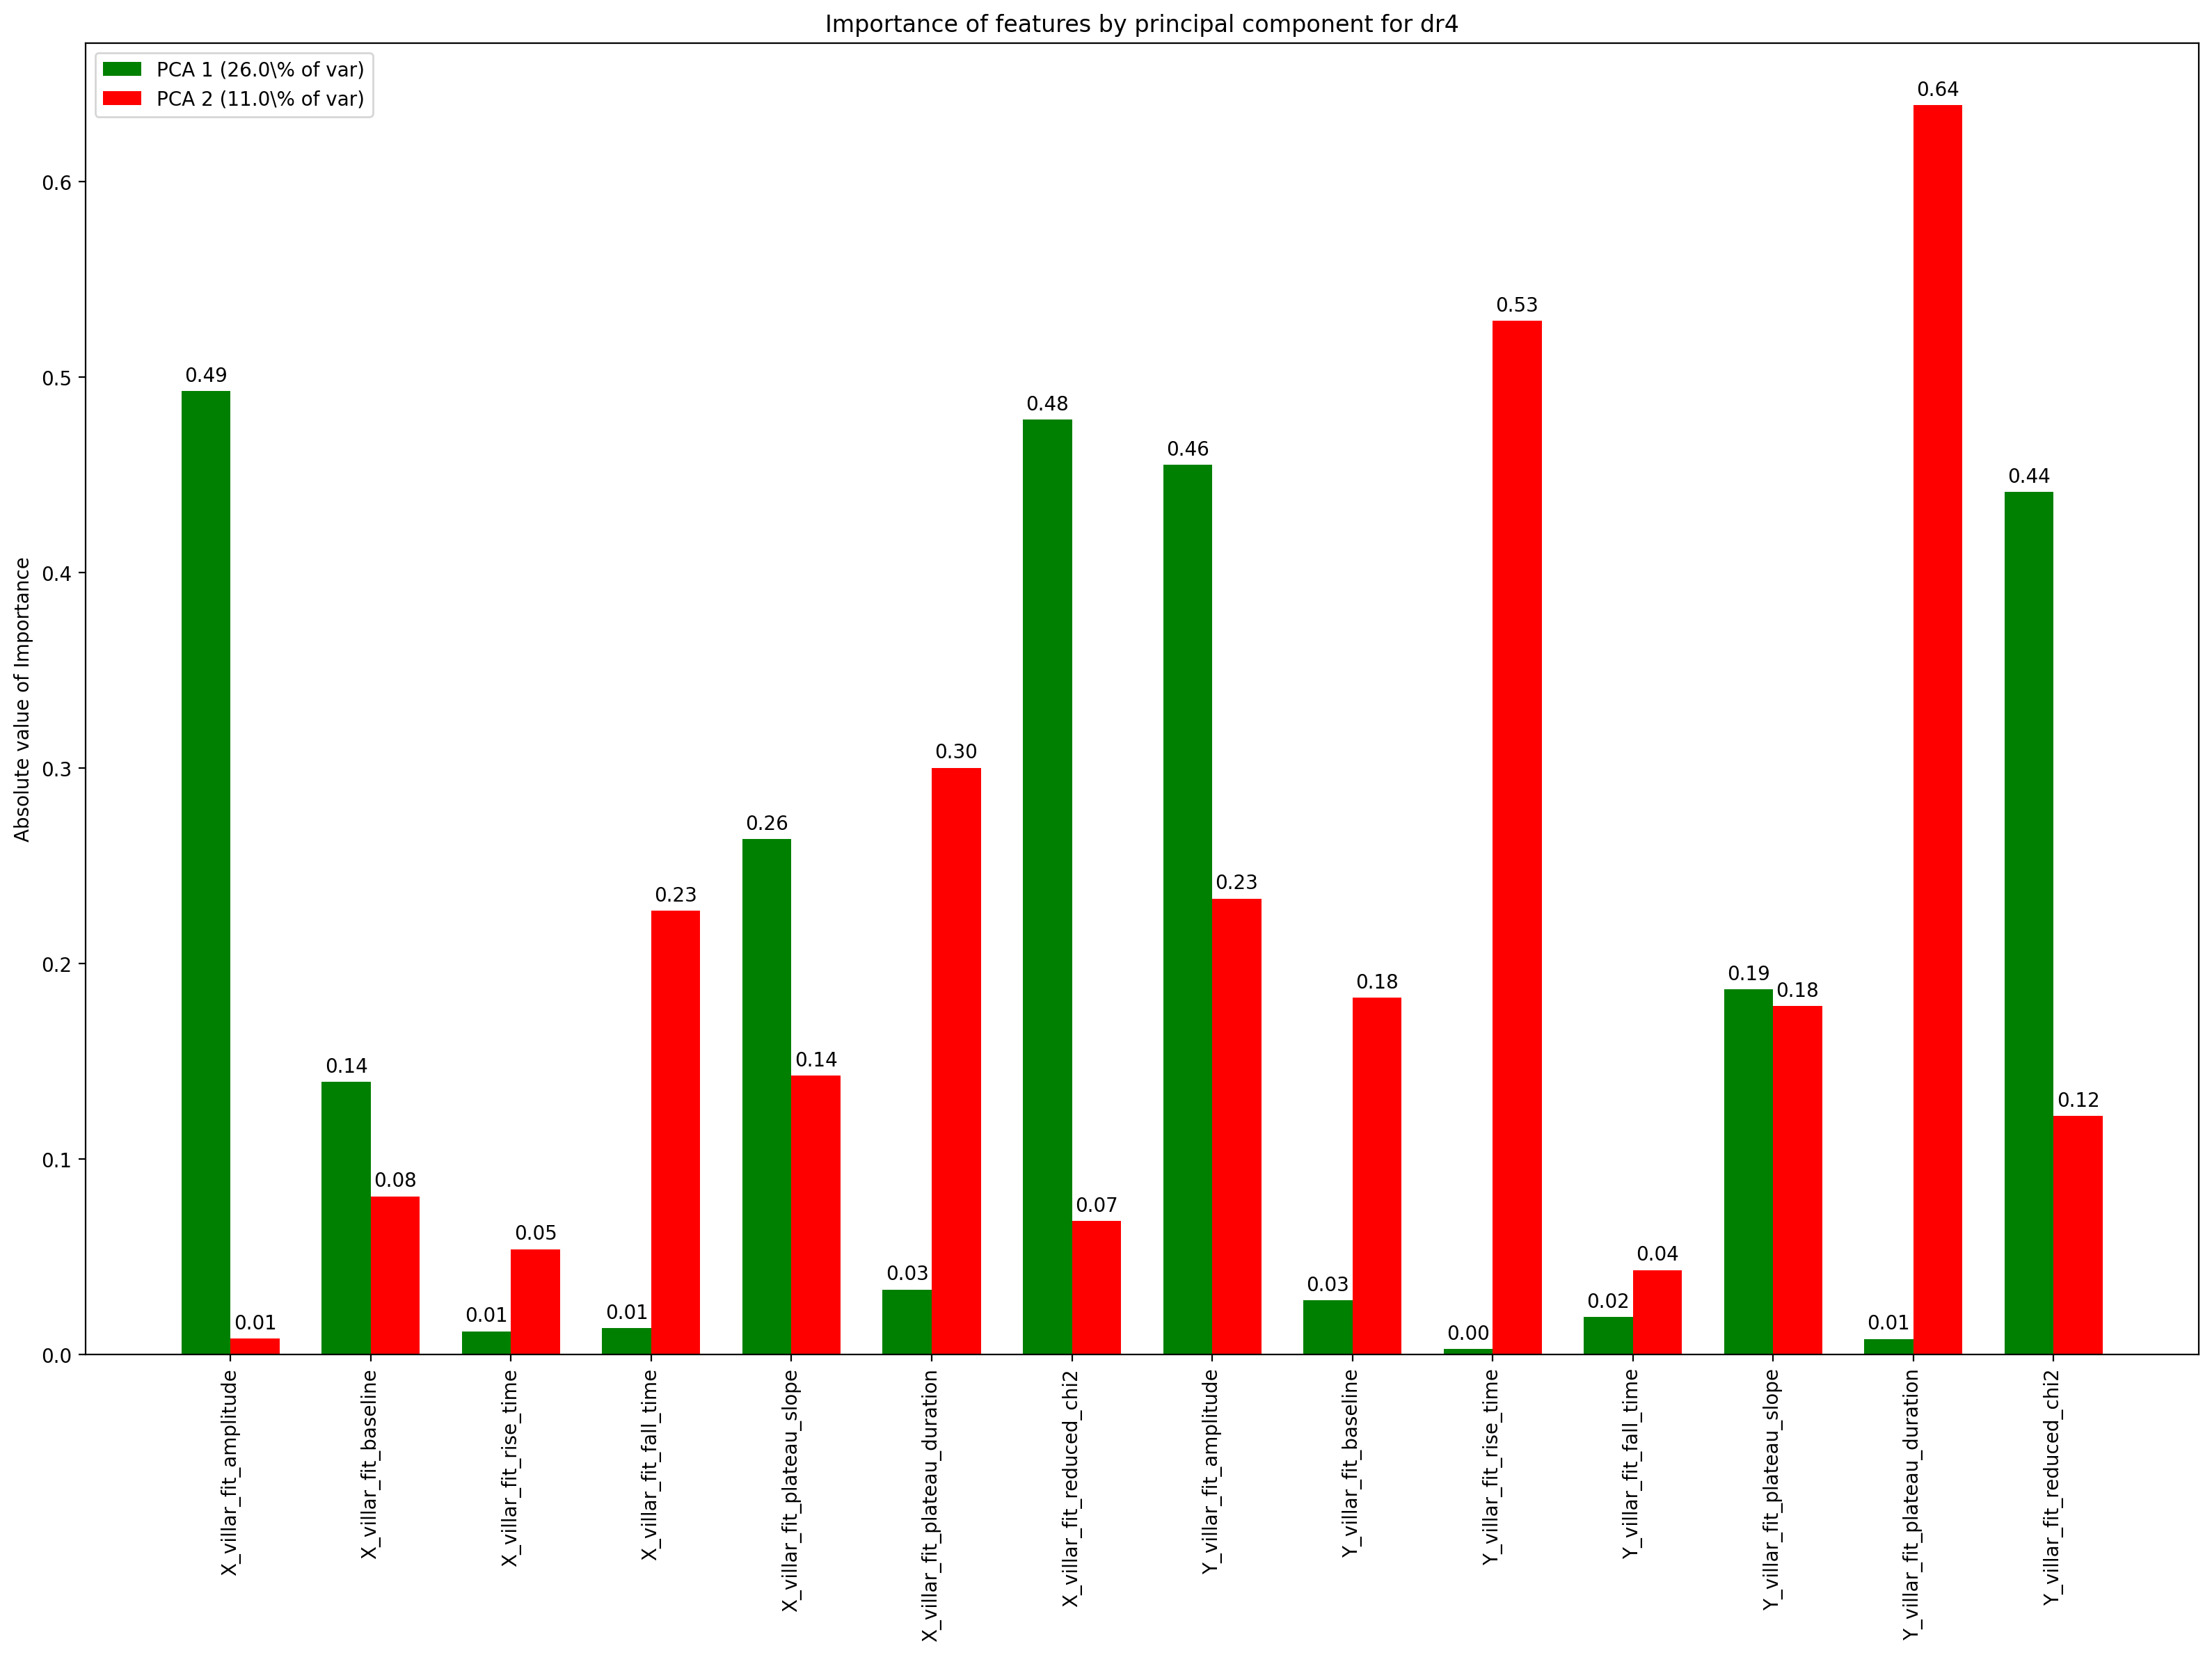

In [21]:
#Shows what PCA consideres the msot important

#cols_latex_read = [r.replace('_', '\_') for r in dr4_df.columns.values]
labels = dr4_df.columns.values
pca1 = abs(np.array(pca_comp.loc[['PCA1']])[0])
pca2 = abs(np.array(pca_comp.loc[['PCA2']])[0])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 12))
rects1 = ax.bar(x - width/2, pca1, width, label=f'PCA 1 ({round(pca_var_ratio[0], 2)*100}\% of var)', color='g')
rects2 = ax.bar(x + width/2, pca2, width, label=f'PCA 2 ({round(pca_var_ratio[1], 2)*100}\% of var)', color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Absolute value of Importance')
ax.set_title('Importance of features by principal component for dr4')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation='vertical')
#ax.set_ylim(0, 0.55)
ax.legend(loc='upper left')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{0:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
#plt.savefig('./figures/pca_feat_importance_barchart.png', dpi=300, bbox_inches='tight')

# Repeat kdtree experiment w/ first 8 PCs (of all 14 features) as input

In [20]:
pcs_X_fakes_df

,0,1,2,3,4,5,6,7
ObjectID,,,,,,,,
_4877922_SNIa,-0.438571,-0.363295,0.219247,-0.179002,-0.103088,0.037320,-0.196169,-0.026946
_1309355_SNIa,-4724.538826,-21623.762508,-28845.217159,37551.258185,123281.173974,275672.642793,48402.135759,255771.838327
_3053534_SNIa,-0.479680,-0.085918,0.259258,-0.109886,-0.037340,0.013119,-0.033366,-0.129866
_3315509_SNIa,-0.420818,2.765126,-1.627507,-0.270707,0.090012,0.009551,0.031486,-0.045830
_4109434_SNIa,-0.317573,-0.493407,-0.314294,0.181468,0.169657,0.025867,-0.007499,-0.313391
...,...,...,...,...,...,...,...,...
_2303364_SNIa,0.234168,-0.393072,-0.166580,0.054349,0.007098,0.018747,-0.044363,-0.187997
_4431841_SNIa,-0.442579,-0.216530,-0.297978,0.032127,0.024021,0.033968,-0.106507,-0.159553
_3414162_SNIa,-0.490665,-0.340492,0.247623,-0.165110,-0.171067,0.032360,-0.197086,0.001216


In [21]:
pcs_X_real_df

NameError: name 'pcs_X_real_df' is not defined

In [ ]:
%%time

# # Reorder SIMIDs to order I want --> Ignore
# fakes_mining_sids = ['6439074373', '9020928999', '6011793767', '4229763628', '6417979422', '6031286883', '604029941']
# fakes_mining_sids_int = list(map(int, fakes_mining_sids))

# pcs_X_fakes_df = pcs_X_fakes_df.reindex(fakes_mining_sids_int)

# KDTREE
#Create a kdtree --> k dimensional binary tree & "plot" all the objects with their 8 dimension
from scipy.spatial import cKDTree

X = np.vstack(pcs_X_real_df.values)
kdtree = cKDTree(np.vstack(pcs_X_fakes_df.values))
ktot=8
dist, ind = kdtree.query(X, k=ktot)

# Save PCA kdtree as pickle
#pickle.dump(kdtree,open('./pca_15pcs_orig_kdtree.p','wb'))

In [ ]:
#Make df that matches the nearest neighbor 1 - 8 from real data to sim
kdtree_results_df = pd.DataFrame()
kdtree_results_df['sid'] = pcs_X_real_df.index
kdtree_results_df = kdtree_results_df.set_index('sid')

kdtree_dist_df = kdtree_results_df.copy()

for knn in range(0,ktot):    
    fakes_match_oid, fakes_match_dist = [],[]
    for ix, dis in zip(ind[:, knn], dist[:, knn]):
        fakes_match_oid.append(fakes_df.iloc[ix].name)
        fakes_match_dist.append(dis)
    kdtree_results_df[f'knn={knn+1}_match_OID'] = fakes_match_oid
    kdtree_dist_df[f'knn={knn+1}_dist'] = fakes_match_dist

In [ ]:
kdtree_results_df = kdtree_results_df
#kdtree_results_df.to_csv("../Tables/real_data_matched_SNIA_sims_titles.csv.gzip", compression='gzip')
kdtree_results_df

In [ ]:
kdtree_dist_df = kdtree_dist_df
#kdtree_dist_df.to_csv("../Tables/real_data_matched_SNIA_sims_distances.csv.gzip", compression='gzip')
# kdtree_dist_df.loc["2021xjh"]
kdtree_dist_df


In [ ]:
# Total real objects matched
print("Total real objects matched:", len(np.hstack(kdtree_results_df.values)))

# Of above, total UNIQUE real objects matched
print("Total real UNIQUE objects matched:", len(np.unique(np.hstack(kdtree_results_df.values))))
print(np.unique(np.hstack(kdtree_results_df.values)))

# Visually inspect closest matches here!

Plan of what to do
1. Define functions to get Real Data and Sim Data
2. Once you have the data, replace MJD w/ days from peak
3. Plot side by side 

In [29]:
def read_snana_fits(dir_path):
    snid_list = []
    meta_list = []
    yse_ztf_fp_df_list = []
    meta = {}
    objid = ""
    if (dir_path == "../Retrain_RAPID/for_YSE/data/PALEO_YSE_MODEL43_CCSNe_V19_yselc_v2_52LCs"):
        objid = "yselc_v2"
    #THIS IS SOMETHING THAT WE WILL NEED TO CHANGE
    elif (dir_path == "/Users/sammysharief/Downloads/YSE_DR1_SIMS_60k_SNR4_grizXY_SIMLIB_FLUXCALERR_COR_220427/PALEO_YSE_ZTF_MODEL01"): #WILL NEED TO UPDATE FOR LOCAL MACHINE
        objid = "SNIa" #Update if not SN Ia
        
    
    
    heads = sorted(glob.glob(os.path.join(dir_path, '*_HEAD.FITS.gz')))
    phots = sorted(glob.glob(os.path.join(dir_path, '*_PHOT.FITS.gz')))
    assert len(heads) != 0, 'no *_HEAD_FITS.gz are found'
    assert len(heads) == len(phots), 'there are different number of HEAD and PHOT files'
    
    for head, phot in zip(heads, phots): #lots of LCs per head, phot files, so do a few to start
        i = head.find('_HEAD.FITS.gz')
        assert head[:i] == phot[:i], f'HEAD and PHOT files name mismatch: {head}, {phot}'
        filename = head[:i].split('/')[-1].split('.')[0]
        head_title = head[88:92] 
        
        for LCnum, lc in enumerate(sncosmo.read_snana_fits(head, phot)): # remember: multiple SN in single HEAD/PHOT file
            #print(lc.meta)
            lc.meta['redshift'] = lc.meta['SIM_REDSHIFT_HOST']
            redshift = lc.meta['redshift']
            mwebv_data = lc.meta['MWEBV']
            salt_mB = lc.meta['SIM_SALT2mB']
            salt_x1 = lc.meta['SIM_SALT2x1']
            salt_c = lc.meta['SIM_SALT2c']
            checkSnid = lc.meta['SNID']
            checkSnid = checkSnid.decode('UTF-8')
        

            
            redshift = np.round(redshift, 2)
            
            
            ra = lc.meta['RA']
            dec = lc.meta['DEC']
            lc.keep_columns(['MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR', 'PHOTFLAG'])
            totalResidual = 0
            fitNew = []
            # Astropy Table --> Pandas df
            df = lc.to_pandas()
            df = df.rename(columns={
                "BAND": "PASSBAND", 
                "FLUXCAL": "FLUX",
                "FLUXCALERR": "FLUXERR", 
                "PHOTFLAG": "PHOTFLAG"
            })
            
            df['PASSBAND']= df['PASSBAND'].str.decode("utf-8") # turn Bytes into str
            snr = []
            snr = df['FLUX']/df['FLUXERR'] 
            df['MAG'] = np.array(-2.5*np.log10(np.abs(df['FLUX'])))+27.5
            magerr = []
            magerr = 1.086/snr
            df['MAGERR'] = magerr
            #Made DF and have all the info
            meta['object_id'] = objid
            meta['RA'] = ra
            meta['DEC'] = dec
            meta['redshift'] = redshift
            meta['SNID'] = checkSnid
            meta['Head'] = head_title
            meta['MWEBV'] = mwebv_data
            meta['mB'] = salt_mB
            meta['x1'] = salt_x1
            meta['c'] = salt_c
            snid_list.append(objid)
            meta_copy = meta.copy()
            meta_list.append(meta_copy)
            yse_ztf_fp_df_list.append(df)
#             meta.clear()
            
    return snid_list, meta_list, yse_ztf_fp_df_list

In [33]:
#Get cur dir
cur_dir = os.getcwd()
cur_dir

'/Users/sammysharief/PGM-Project'

In [34]:
#Get all the data for the respective type --> Real
snid_list_real, meta_list_real, yse_ztf_fp_df_list_real = read_YSE_ZTF_snana_dir(dir_name='/Users/sammysharief/Downloads/YSEphotclass-Sammy/Photpipe/spec_yse_dr1/') 


/Users/sammysharief/Downloads/YSEphotclass-Sammy/Photpipe/spec_yse_dr1/


In [35]:
snid_list_real

[]

This is too big to be on Github so ask Sammy where he put the data
- As of 21/11/2023 @ 4:18pm I have not put it anywhere. I will link in here the DropBox link I will use

In [38]:
#Get all the data for the respective type --> Sim WILL NEED TO CHANGE FOR LOCAL MACHINE
snid_list_real, meta_list_real, yse_ztf_fp_df_list_real = read_YSE_ZTF_snana_dir(dir_name='/Users/sammysharief/Downloads/YSEphotclass-Sammy/Photpipe/spec_yse_dr1/') 


/Users/sammysharief/Downloads/YSEphotclass-Sammy/


In [37]:
print(snid_list_real[0])

print(meta_list_real[0])

print(yse_ztf_fp_df_list_real[0])

IndexError: list index out of range

In [ ]:
print(snid_list_sim[0])

print(meta_list_sim[0])

print(sim_df_list_sim[0])

In [ ]:
'''
2021wfn
2020sag
2020yhn
2021itd issue 
2021kyp
2021mfy
2021mwb
'''
real_object_name = "2021mwb"
sims_object_first_name = kdtree_results_df.loc[real_object_name][0] #The first object
print(sims_object_first_name)
sims_object_second_name = kdtree_results_df.loc[real_object_name][1] #The second object
print(sims_object_second_name)
sims_object_third_name = kdtree_results_df.loc[real_object_name][2] #The third object
print(sims_object_third_name)

In [ ]:
real_villar_fit = []
sim_villar_fit = []
for col in dr4_df.columns:
    real_villar_fit.append(np.round(dr4_df[dr4_df.index == real_object_name][col].values[0],2))
    sim_villar_fit.append(np.round(fakes_df[fakes_df.index == sims_object_first_name][col].values[0] , 2))
    print(col, dr4_df[dr4_df.index == real_object_name][col].values[0])
    print(col, fakes_df[fakes_df.index == sims_object_first_name][col].values[0])
    print()
print(real_villar_fit)
print(sim_villar_fit)
     

# THIS MAKES HISTOGRAMS 

In [ ]:
fig = plt.figure(figsize=(14, 20))
i = 0
with PdfPages(f'Villar_Bazin_{real_object_name}_fit_param_hists.pdf') as pdf:
    for col in dr4_df.columns:
        ax = fig.add_subplot(9, 4, i+1) #42 features
        i = i + 1
        combined = np.append(dr4_df[col].values, fakes_df[col].values)
       
        value = np.abs(dr4_df[dr4_df.index == real_object_name][col].values[0])
        
        if ( value >= 0 and value < 1):
            data_real = np.abs(dr4_df[col])
            _, bins_real = np.histogram(np.log10(data_real + .1), bins=20)
            data_sim = np.abs(fakes_df[col])
            _, bins_sim = np.histogram(np.log10(data_sim + .1), bins=20)
            combined = np.abs(combined)
            _, bin_combined = np.histogram(np.log10(combined + .1), bins=20)
        else:
            data_real = np.abs(dr4_df[col])
            _, bins_real = np.histogram(np.log10(data_real + 1), bins=20)
            data_sim = np.abs(fakes_df[col])
            _, bins_sim = np.histogram(np.log10(data_sim + 1), bins=20)
            combined = np.abs(combined)
            _, bin_combined = np.histogram(np.log10(combined + 1), bins=20)

        
        plt.hist(data_sim, bins=4**bin_combined, color = 'g', label = 'Sim. Sample', density = True, alpha = 0.4)
        plt.hist(data_real, bins=4**bin_combined, color = 'b', label = 'YSE DR1', density = True, alpha = 0.4)
        
        real = round(float(np.abs(data_real[data_real.index == real_object_name])), 2)
        first = round(float(np.abs(data_sim[data_sim.index == sims_object_first_name])), 2)
        second = round(float(np.abs(data_sim[data_sim.index == sims_object_second_name])), 2)
        third = round(float(np.abs(data_sim[data_sim.index == sims_object_third_name])), 2)
        plt.axvline(real, alpha = 1, color = 'r', linewidth = 3, label = real_object_name)

        plt.axvline(first, alpha = 0.7, linestyle = '--', color = 'orange', linewidth = 3, label = sims_object_first_name)
        
        plt.axvline(second, alpha = 0.7, linestyle = '--', color = 'pink', linewidth = 3, label = sims_object_second_name)
        
        plt.axvline(third, alpha = 0.7, linestyle = '--', color = 'cyan', linewidth = 3, label = sims_object_third_name)

        plt.yscale('log')
        plt.gca().set_xscale("log")
        mean = np.round(np.mean(combined), 2)
        median = np.round(np.median(combined), 2)
        stdev = np.round(st.pstdev(combined), 2)
        
        #IF ANY OF THESE ARE MUCH SMALLER THAN 10^-1 JUST MAKE IT 10^-1 
        real_object_valye = np.abs(dr4_df[dr4_df.index == real_object_name][col].values[0])
        real_object_valye = np.round(real_object_valye, 2)
        if (real_object_valye < 10e-1):
            real_object_valye = 10e-1
            plt.axvline(real_object_valye, alpha = 1, color = 'r', linewidth = 3, label = real_object_name)

        fake_object_first_valye = np.abs(fakes_df[fakes_df.index == sims_object_first_name][col].values[0])
        fake_object_first_valye = np.round(fake_object_first_valye, 2)
        if (fake_object_first_valye < 10e-1):
            fake_object_first_valye = 10e-1
            plt.axvline(fake_object_first_valye, linestyle = '--', alpha = 0.7, color = 'orange', linewidth = 3, label = sims_object_first_name)

        fake_object_second_valye = np.abs(fakes_df[fakes_df.index == sims_object_second_name][col].values[0])
        fake_object_second_valye = np.round(fake_object_second_valye, 2)
        if (fake_object_second_valye < 10e-1):
            fake_object_second_valye = 10e-1
            plt.axvline(fake_object_second_valye, linestyle = '--', alpha = 0.7, color = 'pink', linewidth = 3, label = sims_object_second_name)

        fake_object_third_valye = np.abs(fakes_df[fakes_df.index == sims_object_third_name][col].values[0])
        fake_object_third_valye = np.round(fake_object_third_valye, 2)
        if (fake_object_third_valye < 10e-1):
            fake_object_third_valye = 10e-1
            plt.axvline(fake_object_third_valye, linestyle = '--', alpha = 0.7, color = 'cyan', linewidth = 3, label = sims_object_third_name)
        real_sigma = np.round(np.abs(real_object_valye - mean)/stdev, 4)

        sim_first_sigma = np.round(np.abs(fake_object_first_valye - mean)/stdev, 4)

        sim_second_sigma = np.round(np.abs(fake_object_second_valye - mean)/stdev, 4)

        sim_third_sigma = np.round(np.abs(fake_object_third_valye - mean)/stdev, 4)
        if (col ==  'X_villar_fit_amplitude'):
            plt.xlim(4e2, 2.3e4)
        elif(col ==  'X_villar_fit_baseline'):
            plt.xlim(8, 1e4)
        if(col ==  'X_villar_fit_rise_time'):
            plt.xlim(0.9, 5e2)
        elif(col ==  'X_villar_fit_fall_time'):
            plt.xlim(0.9, 6e4)
        elif(col ==  'X_villar_fit_plateau_slope'):
            plt.xlim(1.5, 2e4)
        elif(col ==  'X_villar_fit_plateau_duration'):
            plt.xlim(0.9, 2e2)
        elif(col == 'X_villar_fit_reduced_chi2'):
            plt.xlim(0.9, 5e2)
        elif (col == 'Y_villar_fit_amplitude'):
            plt.xlim(1e2, 2e4)
        elif (col == 'Y_villar_fit_baseline'):
            plt.xlim(0.9, 1e4)
        elif (col == 'Y_villar_fit_rise_time'):
            plt.xlim(0.9, 3e3)
        elif (col == 'Y_villar_fit_fall_time'):
            plt.xlim(1, 1e8)
        elif(col ==  'Y_villar_fit_plateau_slope'):
            plt.xlim(0.5, 1e4)
#         elif(col == 'Y_villar_fit_plateau_duration'):
#             plt.xlim(min_xvalue, max_xvalue)
        elif(col == 'Y_villar_fit_reduced_chi2'):
            plt.xlim(1, 1e2)
        if (col[0] == 'X'):
            xlabel = 'ZTF-g_' + col[13:]
            col = 'ZTF-g_' + col[13:]
        else:
            xlabel = 'ZTF-r_' + col[13:]
            col = 'ZTF-r_' + col[13:]
        plt.xlabel(xlabel)
        if (i == 5):
            plt.ylabel('Normalized Number of Objects', loc = 'top', labelpad = 30, fontsize = 20) # of Objects  
    plt.tight_layout()
    plt.legend(loc='lower right', bbox_to_anchor=(3.5, 0.5), ncol=3, fancybox=True, shadow=True)
    pdf.savefig(bbox_inches='tight')
    plt.close()


# THIS MAKES LIGHT CURVE

In [ ]:
'''
Given:
Real Obj Name, Meta_list, df
AND
Sim Obj Name, snid_list, sim df

We know these objects have villar fits so we can skip the check --> Still need residual check 
'''
plt.style.use('fig_publication-villarfit.mplstyle')
def plotNearesrtNeighbors(real_object_name, meta_list, yse_ztf_fp_df_list, sims_object_name, snid_list, meta_listSim, sim_df_list, plotType = "FLUX", thresehold = 0.5):
    mcmc_niter=(4096)
    d_real = {'X': "ZTF-g", 'Y': "ZTF-r", 'g': "PS1-g", 'r': 'PS1-r', 'i': "PS1-i", 'z': "PS1-z"}
    d_sim = {'X ': "ZTF-g", 'Y ': "ZTF-r", 'g ': "PS1-g", 'r ': 'PS1-r', 'i ': "PS1-i", 'z ': "PS1-z"}
    lmsder_niter=64
    fit = VillarFit('mcmc-lmsder', mcmc_niter=mcmc_niter, lmsder_niter=lmsder_niter) #increase mcmc_niter if fits are not good
    df = pd.DataFrame()   
    mebvExist = 0
    num_of_bands = 0
    no_points_to_plot_mag = 0
    no_points_to_plot_flux = 0
    title = ""
    fig = plt.figure(figsize=(14, 5))
    #CHANGE PATH TO BE WHATEVER YOU WANT
    with PdfPages(f'/Users/sammysharief/Downloads/{real_object_name}_Plots.pdf') as pdf:
        for i in range (0, 2):
            ax = fig.add_subplot(1, 2, i+1) #42 features
            if (i == 0):
                plt.ylim(0, 17000)
                #THIS WILL NEED TO CHANGE IF NOT 2021mwb
                mB = 17.23
                x1 = -1.26
                c = -0.06
                title = f'Real_Data_{plotType}'
                df = yse_ztf_fp_df_list #REAL DATA
                mwebv_data =  meta_list['mwebv']
                mwebv_data = np.round(mwebv_data, 2)
                print("REAL")
                print(type(mwebv_data))
                print(mwebv_data)
                df = df.replace({"PASSBAND": d_real})
                objid = f'{real_object_name} (SNIa)'
                D_id_color = {
                    "ZTF-g": u"#b9ac70",
                    "ZTF-r": u"#bd1f01",
                    "PS1-g": u"#4daf4a",
                    "PS1-r": u"#e41a1c",
                    "PS1-i": u"#832db6",
                    "PS1-z": u"#656364"}
            else:
                plt.xlim(-25, 110)
                plt.ylim(0, 17000)
                mB = np.format_float_positional(meta_listSim['mB'], precision=2) 
                x1 = np.format_float_positional(meta_listSim['x1'], precision=2) 
                c = np.format_float_positional( meta_listSim['c'], precision=2) 
                title =  f'{snid_list}_{plotType}_sims'
                df = sim_df_list #SIMS DATA
                df = df.replace({"PASSBAND": d_sim})
                head = meta_listSim['Head']
                mwebv_data = meta_listSim['MWEBV']
                mwebv_data = np.format_float_positional(mwebv_data, precision=2)
                print("Sim")
                print(type(mwebv_data))
                print(mwebv_data)
                uniqueObjId = meta_listSim['SNID']
                objid = f'SIM ID = {sims_object_name[1:len(sims_object_name)-5]} (SNIa)'
                D_id_color = {
                    "ZTF-g": u"#b9ac70",
                    "ZTF-r": u"#bd1f01",
                    "PS1-g": u"#4daf4a",
                    "PS1-r": u"#e41a1c",
                    "PS1-i": u"#832db6",
                    "PS1-z": u"#656364"}

            df = df.reset_index(drop=True)
        
            df['SNR'] = df['FLUX']/df['FLUXERR'] 
            redshift = meta_list['redshift']
            if (redshift < 0):
                redshift = "N/A"
                
            df2 = df[df['PASSBAND'] == 'ZTF-r']

            peakMJD = df2.loc[df2['FLUX'].idxmax()]['MJD']  
        
            df['MJD'] =  df['MJD'] - peakMJD

            df['PLOTCOLOR'] = df.PASSBAND.map(D_id_color)
            results_pb, models_pb = [], []
            totalResidual = 0
            passband = df['PASSBAND']
            count = 0
            countPlot = 0

            if (plotType == "MAG"):
                plt.gca().invert_yaxis()


            for pb in np.unique(passband):
                
                mask = (df['PASSBAND'] == pb) & (df['PHOTFLAG'] != 0) & (df['SNR'] > 4) & (df['FLUX'] > 0)#no non-detections
                df_pb = df[mask] 
                df_pb = df_pb.sort_values(by=['MJD'], ascending=True) # w/ photpipe, some have (near) duplicate MJDs separated
                df_pb = df_pb.drop_duplicates(subset=['MJD']) # Remove all duplicate MJD rows (prob w/ photpipe output)    
                mjd_pb = np.array(df_pb['MJD'])
                mag_pb = np.array(df_pb['MAG'])
                magerr_pb = np.array(df_pb['MAGERR'])
                flux_pb = np.array(df_pb['FLUX'])
                fluxerr_pb = np.array(df_pb['FLUXERR'])
                passband_pb = np.array(df_pb['PASSBAND'])
                photflag_pb = np.array(df_pb['PHOTFLAG'])
                plotcolor_pb = df_pb['PLOTCOLOR'] 
                if (len(mjd_pb) < 8):
                    df_pb.drop(df_pb.index[df_pb['PASSBAND'] == pb], inplace=True)
                    count = count + 1
                    plt.errorbar(mjd_pb, flux_pb, fluxerr_pb, alpha=0.7, fmt='o', c=np.unique(plotcolor_pb)[0], label=pb, ms = 7.5 ,elinewidth = 2)
                    continue
                else:
                    if (pb == "PS1-g" or pb == "PS1-r" or pb == "PS1-i" or pb == "PS1-z"):
                        continue
                    
                    mjd_pb = np.float64(mjd_pb)
                    flux_pb = np.float64(flux_pb)
                    fluxerr_pb = np.float64(fluxerr_pb)
                    result_pb = fit(mjd_pb, flux_pb, fluxerr_pb, sorted=True) #sorted=True now b/c we use sort_value
                    results_pb.append(result_pb)
                    max_mjd_pb = np.max(mjd_pb)
                    min_mjd_pb = np.min(mjd_pb)
                    day0p1 = (max_mjd_pb-min_mjd_pb)/0.1
                    mjd_grid_pb = np.linspace(min_mjd_pb, max_mjd_pb, int(day0p1))
                    # Minimum number of observations: **8** per band to plot
                    model_pb = VillarFit.model(mjd_grid_pb, result_pb)
                    models_pb.append(model_pb)
                    #Villar fit on actual mjd data so you have the same amount of data points
                    model_pbNew = VillarFit.model(mjd_pb, result_pb) #Just using actual data --> It gives it to you in flux
                    model_pbMagNew = np.array(-2.5*np.log10(np.abs(model_pbNew)))+27.5 #Converting to Mag
                    Residuals_pb = np.abs(mag_pb - model_pbMagNew)
                    df_pb['Residuals'] = np.array(Residuals_pb)
                    if not os.path.exists(f'../Photpipe/yse_ztf_fp_VillarFit_noNonDetect_flux_mcmc_niter={mcmc_niter}_lmsder_niter={lmsder_niter}'):
                        os.makedirs(f'../Photpipe/yse_ztf_fp_VillarFit_noNonDetect_flux_mcmc_niter={mcmc_niter}_lmsder_niter={lmsder_niter}')

                    plt.xlabel('Days from ZTF-r band peak')
                    if (plotType == 'FLUX'):
                        if plt.gca().yaxis_inverted():
                            plt.gca().invert_yaxis()
                        #Flux
                        plt.ylabel('FLUX')
                        plt.errorbar(mjd_pb, flux_pb, fluxerr_pb, alpha=0.7, fmt='o', c=np.unique(plotcolor_pb)[0], label=pb, ms = 7.5, elinewidth = 2)
                        plt.plot(mjd_grid_pb, model_pb, linestyle='dashed', 
                             linewidth=2.5, alpha=0.9, c=np.unique(plotcolor_pb)[0], label=f'{pb}-fit')
                    else:
                        #Mag
                        plt.ylabel('MAG')
                        if plt.gca().yaxis_inverted():
                            plt.errorbar(mjd_pb, mag_pb, magerr_pb, alpha=0.7, fmt='o', c=np.unique(plotcolor_pb)[0], label=pb)
                        else:
                            plt.gca().invert_yaxis()
                            plt.errorbar(mjd_pb, mag_pb, magerr_pb, alpha=0.7, fmt='o', c=np.unique(plotcolor_pb)[0], label=pb)
                    if (type(redshift) == str):
                        redshift = "N/A"
                        plt.title(f'{objid}, z={redshift}, mwebv={mwebv_data}, \n SALT $x_1$: {x1}, $c$: {c}, $m_B$: {mB}')
                    else: 
                        redshift <= 0
                        plt.title(f'{objid}, z={str(round(redshift, 3))}, \n SALT $x_1$: {x1}, $c$: {c}, $m_B$: {mB}')
                if (type(redshift) == str):
                    redshift = "N/A"
                    plt.title(f'{objid}, z={redshift}, mwebv={mwebv_data}, \n SALT $x_1$: {x1}, $c$: {c}, $m_B$: {mB}')
                else: 
                    redshift <= 0
                    plt.title(f'{objid}, z={str(round(redshift, 3))}, mwebv={mwebv_data}, \n SALT $x_1$: {x1}, $c$: {c}, $m_B$: {mB}')
            '''
            Rise Time --> ZTF - g
            Ampltiude -->
            ReducedChi --> 
            '''
            #combined = np.append(dr4_df[col].values, fakes_df[col].values)
            amp_combined = np.append(dr4_df['Y_villar_fit_amplitude'].values, fakes_df['Y_villar_fit_amplitude'].values)
            amp_mean = np.round(np.mean(amp_combined), 2)
            amp_median = np.round(np.median(amp_combined), 2)
            amp_stdev = np.round(st.pstdev(amp_combined), 2)

            gamma_combined = np.append(dr4_df['Y_villar_fit_plateau_duration'].values, fakes_df['Y_villar_fit_plateau_duration'].values)
            gamma_combined_mean = np.round(np.mean(gamma_combined), 2)
            gamma_combined_median = np.round(np.median(gamma_combined), 2)
            gamma_combined_stdev = np.round(st.pstdev(gamma_combined), 2)

            rise_combined = np.append(dr4_df['X_villar_fit_rise_time'].values, fakes_df['X_villar_fit_rise_time'].values)
            rise_mean = np.round(np.mean(rise_combined), 2)
            rise_median = np.round(np.median(rise_combined), 2)
            rise_stdev = np.round(st.pstdev(rise_combined), 2)

            chi_combined =  np.append(dr4_df['X_villar_fit_reduced_chi2'].values, fakes_df['X_villar_fit_reduced_chi2'].values)
            chi_mean = np.round(np.mean(chi_combined), 2)
            chi_median = np.round(np.median(chi_combined), 2)
            chi_stdev = np.round(st.pstdev(chi_combined), 2)
            if (i == 0):
                ampltiude_sigma = np.round(np.abs(real_villar_fit[7] - amp_mean)/amp_stdev, 4)
                gamma_sigma = np.round(np.abs(real_villar_fit[12] - gamma_combined_mean)/gamma_combined_stdev, 4)
                rise_sigma = np.round(np.abs(real_villar_fit[2] - rise_mean)/rise_stdev, 4)
                chi_sigma = np.round(np.abs(real_villar_fit[6] - chi_mean)/chi_stdev, 4)
                
                plt.text(46, 16200, f'ZTF-r $A$: {real_villar_fit[7]} ({ampltiude_sigma}$\sigma$)' )
                plt.text(54, 15200, r'ZTF-r $\gamma$: ' + f'{real_villar_fit[12]} ({gamma_sigma}$\sigma$)')
                plt.text(50, 14200, r'ZTF-g $t_{rise}$: ' + f'{real_villar_fit[2]} ({rise_sigma}$\sigma$)')
                plt.text(33, 13200, r'ZTF-g reduced $\chi^2$: ' + f'{real_villar_fit[6]} ({chi_sigma}$\sigma$)')
            else:
                ampltiude_sigma = np.round(np.abs(sim_villar_fit[7] - amp_mean)/amp_stdev, 4)
                gamma_sigma = np.round(np.abs(sim_villar_fit[12] - gamma_combined_mean)/gamma_combined_stdev, 4)
                rise_sigma = np.round(np.abs(sim_villar_fit[2] - rise_mean)/rise_stdev, 4)
                chi_sigma = np.round(np.abs(sim_villar_fit[6] - chi_mean)/chi_stdev, 4)

                plt.text(45, 16200, f'ZTF-r $A$: {sim_villar_fit[7]} ({ampltiude_sigma}$\sigma$)' )
                plt.text(53.5, 15200, r'ZTF-r $\gamma$: ' + f'{sim_villar_fit[12]} ({gamma_sigma}$\sigma$)')
                plt.text(49.5, 14200, r'ZTF-g $t_{rise}$: ' + f'{sim_villar_fit[2]} ({rise_sigma}$\sigma$)')
                plt.text(29.5, 13100, r'ZTF-g reduced $\chi^2$: ' + f'{sim_villar_fit[6]} ({chi_sigma}$\sigma$)')

        plt.legend(loc='center right', bbox_to_anchor=(0.65, 1.25), ncol=8, fancybox=False, shadow=False, frameon = False)
        pdf.savefig(bbox_inches='tight')  # saves the current figure into a pdf page
        plt.close()

# Find nearest neighbor, make df, and pass it to function above

real_object_namen --> This corresponds to 2021mwb

meta_list --> Dict w/ len of 1 

yse_ztf_fp_df_list 

sims_object_first_name

snid_list_sim

meta_list_sim

sim_df_list_sim

In [ ]:
# sim_df_list_sim = pd.concat(sim_df_list_sim, ignor≈e≈_index=True)

In [ ]:
sims_object_first_name

In [ ]:
target_object_id = "_4791133_SNIa"

# Iterate over the list of dictionaries
for meta_dict in meta_list_sim:
    object_id = meta_dict.get('object_id', '')
    if target_object_id in object_id:
        # Found the object_id, do something with it
        print(f"Object_id {target_object_id} found: {object_id}")
        break
else:
    # Executed if the loop completes without a break (i.e., object_id not found)
    print(f"Object_id {target_object_id} not found in meta_list_sim")

In [ ]:
meta_list

In [ ]:
meta_list_sim

In [ ]:
#snid_list_real, meta_list_real, yse_ztf_fp_df_list_real
for i in range (0, len(snid_list_real)):
    if (snid_list_real[i] == real_object_name):
        meta_list = meta_list_real[i]
        yse_ztf_fp_df_list = yse_ztf_fp_df_list_real[i]  
        print("Real Break")      
        break
#snid_list_sim, meta_list_sim, sim_df_list_sim   
for i in range (0, len(meta_list_sim)):
    part_one = meta_list_sim[i]['Head']
    part_two = meta_list_sim[i]['SNID']
    part_three = meta_list_sim[i]['object_id']
    meta_list_name = '_' + part_two + '_' + part_three
    # print(meta_list_name, sims_object_first_name)
    if (meta_list_name == sims_object_first_name):
        meta_listSim = meta_list_sim[i]
        snid_list = snid_list_sim[i]
        sim_df_list = sim_df_list_sim[i]
        print("SIM BREAK")
        break
        


In [ ]:
meta_listSim

In [ ]:
snid_list

In [ ]:
sim_df_list

In [ ]:
plotNearesrtNeighbors(real_object_name, meta_list, yse_ztf_fp_df_list, sims_object_first_name, snid_list, meta_listSim, sim_df_list, plotType = "FLUX", thresehold = 0.5)